**CatAndDog**


图像分类是根据图像的语义信息将不同类别图像区分开来，是计算机视觉中重要的基本问题

猫狗分类属于图像分类中的粗粒度分类问题

![](https://ai-studio-static-online.cdn.bcebos.com/1cd9ef37036647c2afbbc866a7d2c14179f33cf1e2494d1f8f00de556d231452)

**（1）数据集介绍**

我们使用CIFAR10数据集。CIFAR10数据集包含60,000张32x32的彩色图片，10个类别，每个类包含6,000张。其中50,000张图片作为训练集，10000张作为验证集。这次我们只对其中的猫和狗两类进行预测。

![](https://ai-studio-static-online.cdn.bcebos.com/567016c028714d21bfe690dee70e9ea31512ba3575bd4d7caebbb7ade05c72ac)

# Paddle框架

**首先导入必要的包**  
paddle--->PaddlePaddle深度学习框架  
os------------->python的模块，可使用该模块对操作系统进行操作  
numpy---------->python第三方库，用于进行科学计算  
PIL------------> Python Image Library,python第三方图像处理库  
matplotlib----->python的绘图库 pyplot:matplotlib的绘图框架  
os------------->提供了丰富的方法来处理文件和目录  
sys------------->供对解释器使用或维护的一些变量的访问，以及与解释器强烈交互的函数。  
pickle---------->模块实现了基本的数据序列和反序列化  

In [9]:
# 导入需要的包
import paddle
import numpy as np
from PIL import Image
import sys
import matplotlib.pyplot as plt
import os
import sys 
import pickle
print("本教程基于Paddle的版本号为："+paddle.__version__)
# 确认 Paddle 是否支持 GPU
print("Paddle GPU support:", paddle.is_compiled_with_cuda())

本教程基于Paddle的版本号为：2.6.1
Paddle GPU support: True


## 准备数据

train_reader和test_reader**

自定义读取器处理训练集和测试集

paddle.reader.shuffle()表示每次缓存BUF_SIZE个数据项，并进行打乱

paddle.batch()表示每BATCH_SIZE组成一个batch

In [3]:
#定义数据序列化函数
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

print(unpickle("../data/CatAndDog/cifar-10-batches-py/data_batch_1").keys())
print(unpickle("../data/CatAndDog/cifar-10-batches-py/test_batch").keys())

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
dict_keys([b'batch_label', b'labels', b'data', b'filenames'])


In [5]:
'''
自定义数据集
'''
from paddle.io import Dataset
class MyDataset(paddle.io.Dataset):
    """
    步骤一：继承paddle.io.Dataset类
    """
    def __init__(self, mode='train'):
        """
        步骤二：实现构造函数，定义数据集大小
        """
        super(MyDataset, self).__init__()
        if mode == 'train':
            xs=[]
            ys=[]
            self.data = []
            self.label = []
            #批量读入数据
            for i in range(1,6):
                train_dict=unpickle("../data/CatAndDog/cifar-10-batches-py/data_batch_%d" % (i,))
                xs.append(train_dict[b'data'])
                ys.append(train_dict[b'labels'])
            #拼接数据
            Xtr = np.concatenate(xs)
            Ytr = np.concatenate(ys)
            #数据归一化处理
            for (x,y) in zip(Xtr,Ytr):  
                x= x.flatten().astype('float32')/255.0
                #将数据同一添加到data和label中
                self.data.append(x)
                self.label.append(np.array(y).astype('int64'))
        else:
            self.data = []
            self.label = []
            #读入数据
            test_dict=unpickle("../data/CatAndDog/cifar-10-batches-py/test_batch")
            X=test_dict[b'data']
            Y=test_dict[b'labels']
            for (x,y) in zip(X,Y):  
                #数据归一化处理
                x= x.flatten().astype('float32')/255.0
                #将数据同一添加到data和label中
                self.data.append(x)
                self.label.append(np.array(y).astype('int64'))
    def __getitem__(self, index):
        """
        步骤三：实现__getitem__方法，定义指定index时如何获取数据，并返回单条数据（训练数据，对应的标签）
        """
        #返回单一数据和标签
        data = self.data[index]
        label = self.label[index]
        #注：返回标签数据时必须是int64
        return data, np.array(label, dtype='int64')
    def __len__(self):
        """
        步骤四：实现__len__方法，返回数据集总数目
        """
        #返回数据总数
        return len(self.data)

# 测试定义的数据集
train_dataset = MyDataset(mode='train')
eval_dataset = MyDataset(mode='val')
print('=============train_dataset =============')
#输出数据集的形状和标签
print(train_dataset.__getitem__(1)[0].shape,train_dataset.__getitem__(1)[1])
#输出数据集的长度
print(train_dataset.__len__())
print('=============eval_dataset =============')
#输出数据集的形状和标签
for data, label in eval_dataset:
    print(data.shape, label)
    break
#输出数据集的长度
print(eval_dataset.__len__())

=============train_dataset =============
(3072,) 9
50000
=============eval_dataset =============
(3072,) 3
10000


## 网络配置

**（1）网络搭建**

*** **CNN网络模型**

在CNN模型中，卷积神经网络能够更好的利用图像的结构信息。下面定义了一个较简单的卷积神经网络。显示了其结构：输入的二维图像，先经过三次卷积层、池化层和Batchnorm，再经过全连接层，最后使用softmax分类作为输出层。

![](https://ai-studio-static-online.cdn.bcebos.com/98b9b702cce040fb8a874e28eae6d34ace6025a2c9444cdd954ab5f14d69cfdc)

**池化**是非线性下采样的一种形式，主要作用是通过减少网络的参数来减小计算量，并且能够在一定程度上控制过拟合。通常在卷积层的后面会加上一个池化层。paddlepaddle池化默认为最大池化。是用不重叠的矩形框将输入层分成不同的区域，对于每个矩形框的数取最大值作为输出

**BatchNorm2D**顾名思义是对每batch个数据同时做一个norm。作用就是在深度神经网络训练过程中使得每一层神经网络的输入保持相同分布的。

In [7]:
#定义CNN网络
class MyCNN(paddle.nn.Layer):
    def __init__(self):
        super(MyCNN,self).__init__()
        self.conv0 = paddle.nn.Conv2D(in_channels=3, out_channels=20, kernel_size=5, padding=0)
        self.pool0 = paddle.nn.MaxPool2D(kernel_size =2, stride =2)
        self._batch_norm_0 = paddle.nn.BatchNorm2D(num_features = 20)

        self.conv1 = paddle.nn.Conv2D(in_channels=20, out_channels=50, kernel_size=5, padding=0)
        self.pool1 = paddle.nn.MaxPool2D(kernel_size =2, stride =2)
        self._batch_norm_1 = paddle.nn.BatchNorm2D(num_features = 50)

        self.conv2 = paddle.nn.Conv2D(in_channels=50, out_channels=50, kernel_size=5, padding=0)
        self.pool2 = paddle.nn.MaxPool2D(kernel_size =2, stride =2)
        self.fc1 = paddle.nn.Linear(in_features=50, out_features=10)
    
    def forward(self,input):
        #将输入数据的样子该变成[1,3,32,32]
        input = paddle.reshape(input,shape=[-1,3,32,32])
        x = self.conv0(input)
        x = paddle.nn.functional.relu(x)
        x = self.pool0(x)
        x = self._batch_norm_0(x)

        x = self.conv1(x)
        x = paddle.nn.functional.relu(x)
        x = self.pool1(x)
        x = self._batch_norm_1(x)

        x = self.conv2(x)
        x = paddle.nn.functional.relu(x)
        x = self.pool2(x)
        x = paddle.reshape(x, [x.shape[0], -1])
        x = self.fc1(x)
        y = paddle.nn.functional.softmax(x)
        return y

## 模型训练

In [10]:
# 设置设备为 GPU
paddle.set_device('gpu:0')
#step3:训练模型
# 用Model封装模型
model = paddle.Model(MyCNN())
# 定义损失函数
model.prepare(paddle.optimizer.Adam(parameters=model.parameters()),paddle.nn.CrossEntropyLoss(),paddle.metric.Accuracy(topk=(1,5)))
# 训练可视化VisualDL工具的回调函数
visualdl = paddle.callbacks.VisualDL(log_dir='visualdl_log')
# 启动模型全流程训练
model.fit(train_dataset,            # 训练数据集
           eval_dataset,            # 评估数据集
          epochs=5,            # 总的训练轮次
          batch_size = 256,    # 批次计算的样本量大小
          shuffle=True,             # 是否打乱样本集
          verbose=1,                # 日志展示格式
          save_dir='./chk_points/', # 分阶段的训练模型存储路径
          callbacks=[visualdl])     # 回调函数使用
#保存模型
model.save('../Model/CatAndDog/model_save_dir')

The loss value printed in the log is the current step, and the metric is the average value of previous steps.
Epoch 1/5


/home/yuan/miniconda3/envs/py312/lib/python3.12/site-packages/paddle/nn/layer/norm.py:824: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


step 196/196 [==============================] - loss: 1.9701 - acc_top1: 0.4344 - acc_top5: 0.8636 - 13ms/step          
save checkpoint at /home/yuan/study/Study/AI/code/chk_points/0
Eval begin...
step 40/40 [==============================] - loss: 1.9952 - acc_top1: 0.4602 - acc_top5: 0.8830 - 6ms/step          
Eval samples: 10000
Epoch 2/5
step  10/196 [>.............................] - loss: 1.9159 - acc_top1: 0.5484 - acc_top5: 0.9160 - ETA: 2s - 16ms/step

/home/yuan/miniconda3/envs/py312/lib/python3.12/site-packages/paddle/nn/layer/norm.py:824: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


step 196/196 [==============================] - loss: 1.7842 - acc_top1: 0.5722 - acc_top5: 0.9286 - 12ms/step          
save checkpoint at /home/yuan/study/Study/AI/code/chk_points/1
Eval begin...
step 40/40 [==============================] - loss: 1.7433 - acc_top1: 0.5594 - acc_top5: 0.9321 - 6ms/step          
Eval samples: 10000
Epoch 3/5
step  10/196 [>.............................] - loss: 1.8425 - acc_top1: 0.6047 - acc_top5: 0.9316 - ETA: 2s - 12ms/step

/home/yuan/miniconda3/envs/py312/lib/python3.12/site-packages/paddle/nn/layer/norm.py:824: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


step 196/196 [==============================] - loss: 1.9219 - acc_top1: 0.6248 - acc_top5: 0.9420 - 11ms/step          
save checkpoint at /home/yuan/study/Study/AI/code/chk_points/2
Eval begin...
step 40/40 [==============================] - loss: 1.7510 - acc_top1: 0.5873 - acc_top5: 0.9366 - 6ms/step          
Eval samples: 10000
Epoch 4/5
step  10/196 [>.............................] - loss: 1.7765 - acc_top1: 0.6750 - acc_top5: 0.9523 - ETA: 2s - 14ms/step

/home/yuan/miniconda3/envs/py312/lib/python3.12/site-packages/paddle/nn/layer/norm.py:824: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


step 196/196 [==============================] - loss: 1.8679 - acc_top1: 0.6602 - acc_top5: 0.9503 - 11ms/step          
save checkpoint at /home/yuan/study/Study/AI/code/chk_points/3
Eval begin...
step 40/40 [==============================] - loss: 1.8291 - acc_top1: 0.6218 - acc_top5: 0.9483 - 7ms/step          
Eval samples: 10000
Epoch 5/5
step  10/196 [>.............................] - loss: 1.7646 - acc_top1: 0.6852 - acc_top5: 0.9484 - ETA: 2s - 13ms/step

/home/yuan/miniconda3/envs/py312/lib/python3.12/site-packages/paddle/nn/layer/norm.py:824: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


step 196/196 [==============================] - loss: 1.7320 - acc_top1: 0.6906 - acc_top5: 0.9543 - 11ms/step          
save checkpoint at /home/yuan/study/Study/AI/code/chk_points/4
Eval begin...
step 40/40 [==============================] - loss: 1.9109 - acc_top1: 0.5654 - acc_top5: 0.9490 - 7ms/step          
Eval samples: 10000
save checkpoint at /home/yuan/study/Study/AI/code/chk_points/final


## 模型评估

In [13]:
def load_image(file):
        #打开图片
        im = Image.open(file)
        #将图片调整为跟训练数据一样的大小  32*32，设定ANTIALIAS，即抗锯齿.resize是缩放
        im = im.resize((32, 32), Image.Resampling.LANCZOS)
        #建立图片矩阵 类型为float32
        im = np.array(im).astype(np.float32)
        #矩阵转置 
        im = im.transpose((2, 0, 1))                               
        #将像素值从【0-255】转换为【0-1】
        im = im / 255.0
        #print(im)       
        im = np.expand_dims(im, axis=0)
        # 保持和之前输入image维度一致
        print('im_shape的维度：',im.shape)
        return im

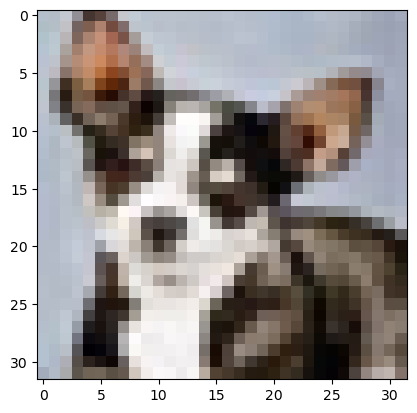

im_shape的维度： (1, 3, 32, 32)
Predict begin...
step 1/1 [==============================] - 17ms/step
Predict samples: 3
results [(array([[2.5423848e-05, 3.0666385e-08, 7.8283553e-11, 2.2281662e-05,
        4.0442023e-09, 9.9995196e-01, 2.0251089e-07, 5.8802971e-09,
        7.1071046e-16, 7.9987402e-08]], dtype=float32),)]
infer results: dog


In [14]:
#定义标签列表
label_list = [ "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse","ship", "truck"]
#读入测试图片并展示
infer_path='../data/CatAndDog/dog.png'
img = Image.open(infer_path)
plt.imshow(img)   
plt.show()    




#载入要预测的图片
infer_img = load_image(infer_path)
#将图片变为数组
infer_img=np.array(infer_img).astype('float32')
#进行预测
result = model.predict(infer_img)
#输出预测结果
print('results',result)
print("infer results: %s" % label_list[np.argmax(result[0][0])])  

# Pytorch 框架

**导入包**：

In [1]:
import torch
import torchvision
import torch.nn as nn                          #神经网络
import torch.optim as optim                    #定义优化器
from torch.utils.data import Dataset,DataLoader
from torchvision import datasets, transforms
from torchvision.transforms.functional import InterpolationMode
from torch import einsum
##模型到处为ONNX
import torch.onnx

import time

import pickle
#from tqdm import tqdm
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import cv2

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

In [2]:
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())  #输出为True，则安装成功
print(torch.backends.cudnn.version())

2.3.0+cu121
12.1
True
8902


**GPU加速**

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 数据准备：  

train_reader和test_reader**

自定义读取器处理训练集和测试集

paddle.reader.shuffle()表示每次缓存BUF_SIZE个数据项，并进行打乱

paddle.batch()表示每BATCH_SIZE组成一个batch

In [4]:
#定义数据序列化函数
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

print(unpickle("../data/CatAndDog/cifar-10-batches-py/data_batch_1").keys())
print(unpickle("../data/CatAndDog/cifar-10-batches-py/test_batch").keys())

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
dict_keys([b'batch_label', b'labels', b'data', b'filenames'])


**定义自定义数据集类**：

In [5]:
class MyDataset(Dataset):
    """
    继承 torch.utils.data.Dataset 类
    """
    def __init__(self, mode='train', transform=None,path="../data"):
        """
        初始化函数，定义数据集大小和转换
        Args:
            mode (str): 数据集模式，'train' 表示训练集，'val' 表示验证集，默认为 'train'。
            transform (callable, optional): 数据预处理函数，默认为 None。
        """
        self.path = path
        self.mode = mode
        self.transform = transform
        
        if mode == 'train':
            xs = []
            ys = []
            self.data = []
            self.label = []
            # 批量读入数据
            for i in range(1, 6):
                train_dict = unpickle("../data/CatAndDog/cifar-10-batches-py/data_batch_%d" % (i,))
                xs.append(train_dict[b'data'])  # 使用extend而不是append
                ys.append(train_dict[b'labels'])
            # 拼接数据
            Xtr = np.concatenate(xs)
            Ytr = np.concatenate(ys)
            # 数据归一化处理
            for (x, y) in zip(Xtr, Ytr):
                #x = x.flatten().astype('float32') / 255.0
                # 将数据统一添加到 data 和 label 中
                x = x.reshape((3, 32, 32)).astype('float32') / 255.0  # 恢复形状并归一化
                self.data.append(x)
                self.label.append(np.array(y, dtype='int64'))
                
        else:
            self.data = []
            self.label = []
            # 读入数据
            test_dict = unpickle("../data/CatAndDog/cifar-10-batches-py/test_batch")
            X = test_dict[b'data']
            Y = test_dict[b'labels']
            for (x, y) in zip(X, Y):
                #x = x.reshape((3, 32, 32))
                # 数据归一化处理
                #x = x.flatten().astype('float32') / 255.0
                # 将数据统一添加到 data 和 label 中
                x = x.reshape((3, 32, 32)).astype('float32') / 255.0  # 恢复形状并归一化
                self.data.append(x)
                self.label.append(np.array(y, dtype='int64'))

    def __getitem__(self, index):
        """
        返回指定 index 的数据和标签
        """
        data = self.data[index]
        label = self.label[index]
        
        #如果有transform，应用到数据上
        if self.transform:
            # 需要将numpy数组转换为PIL Image，然后应用transform，最后转回Tensor
            img = Image.fromarray((data * 255).astype(np.uint8).transpose((1, 2, 0)))  # 注意通道顺序转换
            data = self.transform(img)
            
        # 返回数据和标签
        return data , torch.tensor(label, dtype=torch.int64)

    def __len__(self):
        """
        返回数据集总数目
        """
        return len(self.data)
    
    def __repr__(self):
        """
        返回数据集的描述信息
        """
        return f"""Dataset {self.__class__.__name__}
        Number of datapoints: {len(self)}
        Root location: {self.path}
        Split: {self.mode.capitalize()}
        StandardTransform
    Transform: {self.transform}"""

**测试自定义数据集**:

In [6]:
# 定义数据转换
transform_train = transforms.Compose([
    #transforms.Resize((224, 224), interpolation=InterpolationMode.BICUBIC),
    transforms.RandomHorizontalFlip(),
    transforms.RandomGrayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
transform_test = transforms.Compose([
    #transforms.Resize((224, 224), interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# 创建训练和验证数据集
path = "../data/CatAndDog/cifar-10-batches-py/"
train_dataset = MyDataset(mode='train', transform=transform_train,path=path)
eval_dataset = MyDataset(mode='val', transform=transform_test,path=path)

print(train_dataset)
print(eval_dataset)

#输出数据集的形状和标签
print(train_dataset.__getitem__(1)[0].shape,train_dataset.__getitem__(1)[1])
#输出数据集的长度
print(train_dataset.__len__())


# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=64, shuffle=False)

# 输出训练数据集的形状和标签
for data, label in train_loader:
    print(data.shape, label.shape)
    break

# 输出验证数据集的形状和标签
for data, label in eval_loader:
    print(data.shape, label.shape)
    break

# 输出数据集的长度
print('Training dataset size:', len(train_dataset))
print('Validation dataset size:', len(eval_dataset))

Dataset MyDataset
        Number of datapoints: 50000
        Root location: ../data/CatAndDog/cifar-10-batches-py/
        Split: Train
        StandardTransform
    Transform: Compose(
    RandomHorizontalFlip(p=0.5)
    RandomGrayscale(p=0.1)
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Dataset MyDataset
        Number of datapoints: 10000
        Root location: ../data/CatAndDog/cifar-10-batches-py/
        Split: Val
        StandardTransform
    Transform: Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
torch.Size([3, 32, 32]) tensor(9)
50000
torch.Size([64, 3, 32, 32]) torch.Size([64])
torch.Size([64, 3, 32, 32]) torch.Size([64])
Training dataset size: 50000
Validation dataset size: 10000


## AlexNet

### 网络定义

In [7]:
class MyAlexNet(nn.Module):
    def __init__(self, num_classes=10, width_mult=1):
        super(MyAlexNet, self).__init__()

        self.conv1_seq = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=7, padding=1,stride=1),
            nn.BatchNorm2d(96),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.ReLU(inplace=True)
        )

        self.conv2_seq = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.ReLU(inplace=True),
        )

        self.conv3_seq = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True)
        )

        self.conv4_seq = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True)
        )

        self.conv5_seq = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.ReLU(inplace=True),
        )

        self.flatten = nn.Flatten()

        self.fc1 = nn.Sequential(nn.Linear(2*2*256, 512),
                                 nn.ReLU())
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Sequential(nn.Linear(512, 512),
                                 nn.ReLU())
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(512, num_classes)

    def forward(self, out):
        out = out.reshape(shape=[-1,3,32,32])
        x = self.conv1_seq(out)
        x = self.conv2_seq(x)
        x = self.conv3_seq(x)
        x = self.conv4_seq(x)
        x = self.conv5_seq(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

In [8]:
myAlexNet = MyAlexNet().to(device)
#将模型转换到device中，并将其结构显示出来
print(myAlexNet) 

MyAlexNet(
  (conv1_seq): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU(inplace=True)
  )
  (conv2_seq): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU(inplace=True)
  )
  (conv3_seq): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv4_seq): Sequential(
    (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(384, eps=1e-05, momentu

### 定义超参数/优化器和损失函数

In [9]:
#定义超参数
#input_size = 28 * 28  #输入大小
#hidden_size = 512 #隐藏层大小
#num_classes = 10 #输出大小（类别数）
batch_size = 256 #批大小
learning_rate = 0.001 #学习率
num_epochs = 10 #训练轮数

In [10]:
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
# CrossEntropyLoss = Softmax + log + nllloss
optimizer = optim.Adam(myAlexNet.parameters(), lr=learning_rate)
# optimizer = optim.SGD(model.parameters(),0.2)

### 数据处理

In [11]:
#数据处理
#构建数据集和测试集的DataLoader
trainDataLoader = DataLoader(dataset = train_dataset,
                             batch_size = batch_size,
                             shuffle = True
                             )
testDataLoader = DataLoader(dataset = eval_dataset,batch_size = batch_size,shuffle = True)

# trainDataLoader.to(device)
# testDataLoader.to(device)

Batch Images Shape: torch.Size([256, 3, 32, 32])
Batch Labels: tensor([8, 6, 5, 6, 6])


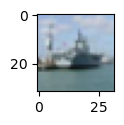

In [12]:
import numpy as np

# 假设你的transform_train包含 Normalize(mean, std)，这里是逆转这部分操作
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])

def reverse_normalize(images, mean, std):
    """逆向Normalize操作，确保正确广播均值和标准差"""
    # 确保mean和std可以广播到images的形状上
    mean_broadcast = mean.reshape(1, -1, 1, 1)  # 形状变为(1,3,1,1)以便于广播
    std_broadcast = std.reshape(1, -1, 1, 1)   # 同理
    return images * std_broadcast + mean_broadcast

# 在显示图像前，先逆向Normalize操作
for images, labels in trainDataLoader:
    print(f"Batch Images Shape: {images.shape}")
    print(f"Batch Labels: {labels[:5]}")  # 只显示前5个标签
    # 转换为numpy数组以便在numpy中操作
    images_np = images.numpy()
    # 逆向Normalize
    original_images = reverse_normalize(images_np, mean, std)
    # 显示第一张图像
    plt.figure(figsize=(1, 1))
    plt.imshow(original_images[0].transpose(1, 2, 0))  # 注意，这里可能需要调整通道顺序以匹配matplotlib的期望
    plt.show()
    break  # 只显示一个批次的数据后跳出循环

### 模型训练

#### 计算TOP-K 准确率

In [13]:
# Helper function to calculate top-k accuracy
def top_k_accuracy(output, target, k=5):
    with torch.no_grad():
        max_k = max((1, k))
        batch_size = target.size(0)

        _, pred = output.topk(max_k, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in (1, k):
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

#### 测试训练

In [14]:
myAlexNet.train()
for batch_idx, (trainImgs, labels) in enumerate(trainDataLoader):
    trainImgs = trainImgs.to(device)
    labels = labels.to(device)

    outputs = myAlexNet(trainImgs)
    ##测试函数
    print(f"Outputs data type: {outputs.dtype}")
    print(f"Labels data type: {labels.dtype}")
    print(f"Output shape: {outputs.shape}")
    print(f"Labels shape: {labels.shape}")
    if outputs.device == labels.device:
        print("模型的输出和标签在同一个设备上")
    else:
        print("模型的输出和标签不在同一个设备上，请将它们移动到相同的设备上")
    ##
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    print(f"Training Loss at batch index {batch_idx}: {loss.item():.4f}")
    break

Outputs data type: torch.float32
Labels data type: torch.int64
Output shape: torch.Size([256, 10])
Labels shape: torch.Size([256])
模型的输出和标签在同一个设备上
Training Loss at batch index 0: 2.3379


#### 正式训练

In [15]:
# 初始化空列表用于存储历史数据
train_loss = []
train_accuracy_top1 = []
train_accuracy_top5 = []
train_epoch_loss = []
train_epoch_accuracy_top1 = []
train_epoch_accuracy_top5 = []

test_loss = []
test_accuracy_top1 = []
test_accuracy_top5 = []

def train(dataloader, model, lossF, optimizer, num_epochs, test_dataloader):
    for epoch in range(num_epochs):
        sum_loss = 0.0
        sum_correct_top1 = 0.0
        sum_correct_top5 = 0.0
        total_samples = 0.0
        model.train()
        processBar = tqdm(dataloader, unit='step')
        for batch, (trainImgs, labels) in enumerate(processBar):
            trainImgs, labels = trainImgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(trainImgs)
            loss = lossF(outputs, labels)

            
            top1_acc, top5_acc = top_k_accuracy(outputs, labels, k=5)
            
            train_loss.append(loss.item())
            train_accuracy_top1.append(top1_acc.item())
            train_accuracy_top5.append(top5_acc.item())
            
            predictions = torch.argmax(outputs, dim=1)
            correct = torch.sum(predictions == labels).item()
            accuracy = correct / labels.size(0)
            
#             train_loss.append(loss)  # 假设epoch_loss_value是你计算得到的当前epoch的训练损失
#             train_accuracy.append(accuracy)  # 假设epoch_accuracy_value是你计算得到的当前epoch的训练精度
            
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()
            sum_correct_top1 += top1_acc.item()
            sum_correct_top5 += top5_acc.item()
            total_samples += labels.size(0)
    
            processBar.set_description(f"Epoch: {epoch+1}/{num_epochs} ; Loss: {loss.item():.4f} Top-1 Acc: {top1_acc.item():.4f}% Top-5 Acc: {top5_acc.item():.4f}%")

        avg_epoch_loss = sum_loss / len(dataloader)
        avg_epoch_accuracy_top1 = sum_correct_top1 / len(dataloader)
        avg_epoch_accuracy_top5 = sum_correct_top5 / len(dataloader)
        train_epoch_loss.append(avg_epoch_loss)
        train_epoch_accuracy_top1.append(avg_epoch_accuracy_top1)
        train_epoch_accuracy_top5.append(avg_epoch_accuracy_top5)
        print(f"Epoch {epoch+1} - Average training loss: {avg_epoch_loss:.4f}, Top-1 Accuracy: {avg_epoch_accuracy_top1:.4f}%, Top-5 Accuracy: {avg_epoch_accuracy_top5:.4f}%")

        # 每个epoch结束后，进行一次测试
        model.eval()
        with torch.no_grad():
            test_acc_top1, test_acc_top5, test_l = test(test_dataloader, model, lossF)
            test_loss.append(test_l)
            test_accuracy_top1.append(test_acc_top1)
            test_accuracy_top5.append(test_acc_top5)
            print(f"Epoch {epoch+1} - Test Top-1 accuracy: {test_acc_top1:.4f}%, Test Top-5 accuracy: {test_acc_top5:.4f}%, Test loss: {test_l:.4f}")

def test(dataloader, model, lossF):
    sum_loss = 0.0
    sum_correct_top1 = 0.0
    sum_correct_top5 = 0.0
    total_samples = 0.0
    for batch, (testImgs, labels) in enumerate(dataloader):
        testImgs, labels = testImgs.to(device), labels.to(device)
        outputs = model(testImgs)
        loss = lossF(outputs, labels)

        top1_acc, top5_acc = top_k_accuracy(outputs, labels, k=5)

        sum_loss += loss.item()
        sum_correct_top1 += top1_acc.item()
        sum_correct_top5 += top5_acc.item()
        total_samples += labels.size(0)

    avg_loss = sum_loss / len(dataloader)
    avg_accuracy_top1 = sum_correct_top1 / len(dataloader)
    avg_accuracy_top5 = sum_correct_top5 / len(dataloader)

    return avg_accuracy_top1, avg_accuracy_top5, avg_loss

# 开始训练
num_epochs = 10
train(trainDataLoader, myAlexNet, criterion, optimizer, num_epochs, testDataLoader)

  0%|          | 0/196 [00:00<?, ?step/s]

Epoch 1 - Average training loss: 1.5396, Top-1 Accuracy: 41.9061%, Top-5 Accuracy: 90.3563%
Epoch 1 - Test Top-1 accuracy: 53.4082%, Test Top-5 accuracy: 93.5547%, Test loss: 1.3099


  0%|          | 0/196 [00:00<?, ?step/s]

Epoch 2 - Average training loss: 1.1325, Top-1 Accuracy: 60.2806%, Top-5 Accuracy: 95.4070%
Epoch 2 - Test Top-1 accuracy: 63.9844%, Test Top-5 accuracy: 96.0742%, Test loss: 1.0266


  0%|          | 0/196 [00:00<?, ?step/s]

Epoch 3 - Average training loss: 0.9429, Top-1 Accuracy: 67.5426%, Top-5 Accuracy: 96.7184%
Epoch 3 - Test Top-1 accuracy: 69.0430%, Test Top-5 accuracy: 96.6797%, Test loss: 0.8964


  0%|          | 0/196 [00:00<?, ?step/s]

Epoch 4 - Average training loss: 0.8202, Top-1 Accuracy: 72.0476%, Top-5 Accuracy: 97.4558%
Epoch 4 - Test Top-1 accuracy: 71.1523%, Test Top-5 accuracy: 97.0605%, Test loss: 0.8449


  0%|          | 0/196 [00:00<?, ?step/s]

Epoch 5 - Average training loss: 0.7298, Top-1 Accuracy: 75.4042%, Top-5 Accuracy: 97.8886%
Epoch 5 - Test Top-1 accuracy: 73.4375%, Test Top-5 accuracy: 97.5684%, Test loss: 0.7807


  0%|          | 0/196 [00:00<?, ?step/s]

Epoch 6 - Average training loss: 0.6579, Top-1 Accuracy: 77.8512%, Top-5 Accuracy: 98.3490%
Epoch 6 - Test Top-1 accuracy: 74.5410%, Test Top-5 accuracy: 98.4082%, Test loss: 0.7468


  0%|          | 0/196 [00:00<?, ?step/s]

Epoch 7 - Average training loss: 0.6019, Top-1 Accuracy: 79.9709%, Top-5 Accuracy: 98.5407%
Epoch 7 - Test Top-1 accuracy: 79.2285%, Test Top-5 accuracy: 98.5449%, Test loss: 0.6024


  0%|          | 0/196 [00:00<?, ?step/s]

Epoch 8 - Average training loss: 0.5424, Top-1 Accuracy: 81.9655%, Top-5 Accuracy: 98.8138%
Epoch 8 - Test Top-1 accuracy: 75.2051%, Test Top-5 accuracy: 98.1152%, Test loss: 0.7555


  0%|          | 0/196 [00:00<?, ?step/s]

Epoch 9 - Average training loss: 0.5014, Top-1 Accuracy: 83.2797%, Top-5 Accuracy: 98.9629%
Epoch 9 - Test Top-1 accuracy: 80.4883%, Test Top-5 accuracy: 98.6328%, Test loss: 0.5881


  0%|          | 0/196 [00:00<?, ?step/s]

Epoch 10 - Average training loss: 0.4561, Top-1 Accuracy: 84.7118%, Top-5 Accuracy: 99.1323%
Epoch 10 - Test Top-1 accuracy: 80.8203%, Test Top-5 accuracy: 98.4180%, Test loss: 0.5758


### 模型训练可视化

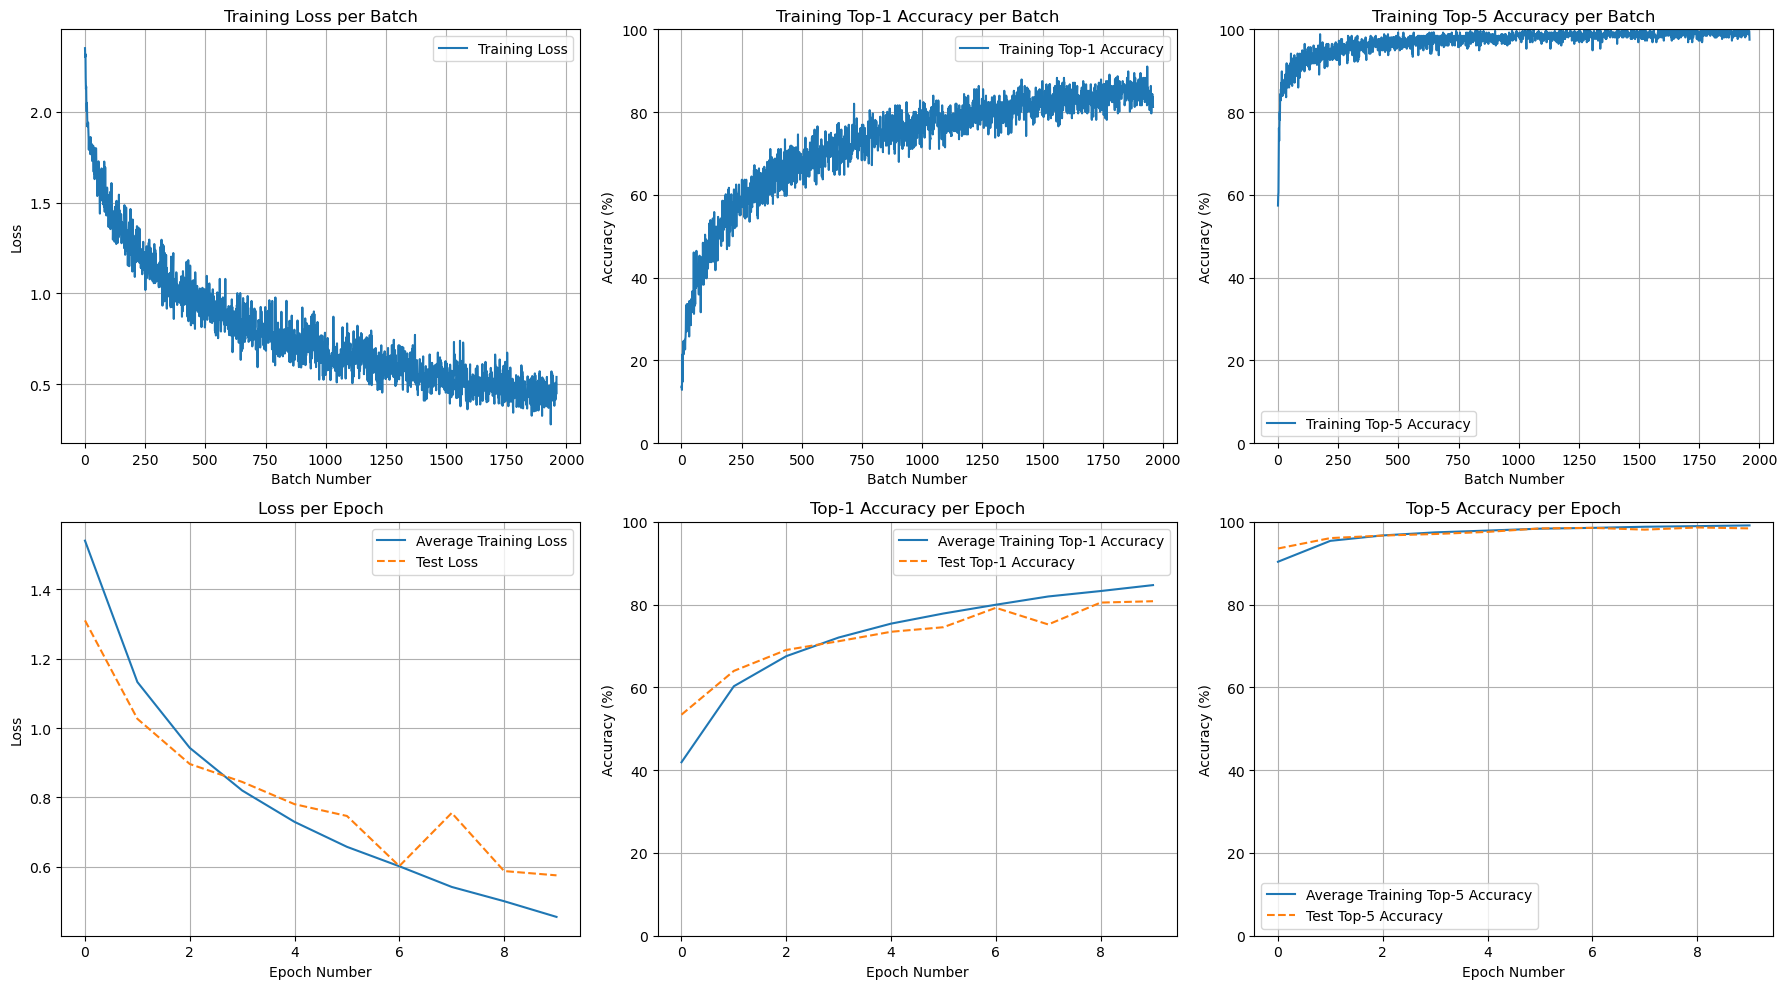

In [16]:
# 可视化代码
import numpy as np
import matplotlib.pyplot as plt

# 确保转换回CPU并转换成numpy数组
train_loss = np.array(train_loss)
train_accuracy_top1 = np.array(train_accuracy_top1)
train_accuracy_top5 = np.array(train_accuracy_top5)
train_epoch_loss = np.array(train_epoch_loss)
train_epoch_accuracy_top1 = np.array(train_epoch_accuracy_top1)
train_epoch_accuracy_top5 = np.array(train_epoch_accuracy_top5)

test_loss = np.array(test_loss)
test_accuracy_top1 = np.array(test_accuracy_top1)
test_accuracy_top5 = np.array(test_accuracy_top5)

plt.figure(figsize=(18, 10))

# 绘制训练损失曲线
plt.subplot(2, 3, 1)
plt.plot(range(len(train_loss)), train_loss, label='Training Loss')
plt.title('Training Loss per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# 绘制训练Top-1准确率曲线
plt.subplot(2, 3, 2)
plt.plot(range(len(train_accuracy_top1)), train_accuracy_top1, label='Training Top-1 Accuracy')
plt.title('Training Top-1 Accuracy per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Accuracy (%)')
plt.ylim([0, 100])
plt.grid(True)
plt.legend()

# 绘制训练Top-5准确率曲线
plt.subplot(2, 3, 3)
plt.plot(range(len(train_accuracy_top5)), train_accuracy_top5, label='Training Top-5 Accuracy')
plt.title('Training Top-5 Accuracy per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Accuracy (%)')
plt.ylim([0, 100])
plt.grid(True)
plt.legend()

# 绘制每个epoch的平均训练损失曲线
plt.subplot(2, 3, 4)
plt.plot(range(len(train_epoch_loss)), train_epoch_loss, label='Average Training Loss')
plt.plot(range(len(test_loss)), test_loss, label='Test Loss', linestyle='--')
plt.title('Loss per Epoch')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# 绘制每个epoch的平均训练Top-1准确率曲线
plt.subplot(2, 3, 5)
plt.plot(range(len(train_epoch_accuracy_top1)), train_epoch_accuracy_top1, label='Average Training Top-1 Accuracy')
plt.plot(range(len(test_accuracy_top1)), test_accuracy_top1, label='Test Top-1 Accuracy', linestyle='--')
plt.title('Top-1 Accuracy per Epoch')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy (%)')
plt.ylim([0, 100])
plt.grid(True)
plt.legend()

# 绘制每个epoch的平均训练Top-5准确率曲线
plt.subplot(2, 3, 6)
plt.plot(range(len(train_epoch_accuracy_top5)), train_epoch_accuracy_top5, label='Average Training Top-5 Accuracy')
plt.plot(range(len(test_accuracy_top5)), test_accuracy_top5, label='Test Top-5 Accuracy', linestyle='--')
plt.title('Top-5 Accuracy per Epoch')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy (%)')
plt.ylim([0, 100])
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

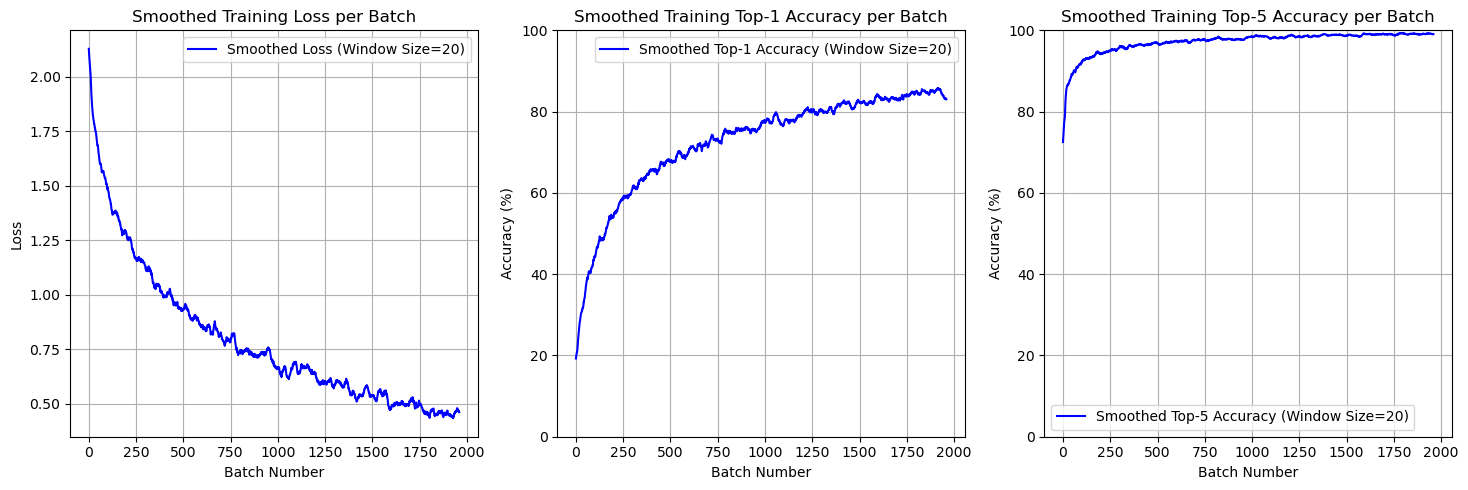

In [17]:
def smooth_curve(points, window_size):
    """
    对数据点进行移动平均平滑处理。
    :param points: 原始数据点列表
    :param window_size: 平滑窗口的大小
    :return: 平滑后的数据点列表
    """
    if window_size < 2:
        return points
    
    smoothed_points = []
    for idx in range(len(points)):
        start = max(0, idx - window_size//2)
        end = min(len(points), idx + window_size//2 + 1)
        window = points[start:end]
        avg = sum(window) / len(window)
        smoothed_points.append(avg)
    
    return smoothed_points

# 平滑数据
window_size = 20
smoothed_train_loss = smooth_curve(train_loss, window_size)
smoothed_train_accuracy_top1 = smooth_curve(train_accuracy_top1, window_size)
smoothed_train_accuracy_top5 = smooth_curve(train_accuracy_top5, window_size)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(smoothed_train_loss, label=f'Smoothed Loss (Window Size={window_size})', color='blue')
plt.title('Smoothed Training Loss per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# 绘制平滑后的训练Top-1准确率曲线
plt.subplot(1, 3, 2)
plt.plot(smoothed_train_accuracy_top1, label=f'Smoothed Top-1 Accuracy (Window Size={window_size})', color='blue')
plt.title('Smoothed Training Top-1 Accuracy per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Accuracy (%)')
plt.ylim([0, 100])
plt.grid(True)
plt.legend()

# 绘制平滑后的训练Top-5准确率曲线
plt.subplot(1, 3, 3)
plt.plot(smoothed_train_accuracy_top5, label=f'Smoothed Top-5 Accuracy (Window Size={window_size})', color='blue')
plt.title('Smoothed Training Top-5 Accuracy per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Accuracy (%)')
plt.ylim([0, 100])
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

### 模型保存并重新加载

In [18]:
# 定义一个函数来保存模型
def save_model(model, optimizer, filename='../Model/model.pth'):
    state = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(state, filename)
    print(f'Model and optimizer state saved to {filename}')

# 定义一个函数来加载模型
def load_model(model, optimizer, filename='../Model/model.pth'):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print(f'Model and optimizer state loaded from {filename}')

# ...（训练部分保持不变）
# 假设mylenet是你的模型实例，optimizer是你的优化器实例
save_model(myAlexNet, optimizer,filename = '../Model/CatAndDog/MyAlexNet.pth')

# 稍后若要恢复训练或使用模型：
# 加载模型和优化器状态
load_model(myAlexNet, optimizer,filename = '../Model/CatAndDog/MyAlexNet.pth')

Model and optimizer state saved to ../Model/CatAndDog/MyAlexNet.pth
Model and optimizer state loaded from ../Model/CatAndDog/MyAlexNet.pth


In [19]:
# 假设model是已加载并设置为eval模式的ResNet模型
myAlexNet.eval()

# 定义模型的输入形状，根据您的实际情况调整
input_shape = (1, 3, 32, 32)  # 调整为您的输入尺寸

# 创建一个与模型输入尺寸匹配的dummy_input
dummy_input = torch.randn(input_shape, device=myAlexNet.parameters().__next__().device)  # 使用随机数据作为示例输入，并放置在与模型相同的设备上


# 导出模型到ONNX
onnx_file_path = "../Model/CatAndDog/MyAlexNet.onnx"
torch.onnx.export(myAlexNet,               # 要导出的模型
                  dummy_input,         # 示例输入数据
                  onnx_file_path,      # 输出的ONNX文件路径
                  export_params=True,  # 将模型参数包含进ONNX文件
                  opset_version=11,    # ONNX操作集版本，选择适合您需求的版本
                  do_constant_folding=True,  # 执行常量折叠优化
                  input_names = ['input'],   # 输入的名称
                  output_names = ['output'],  # 输出的名称
                  dynamic_axes={'input': {0: 'batch_size'},    # 动态轴，允许batch_size变化
                               'output': {0: 'batch_size'}})

print(f"Model has been successfully converted to ONNX: {onnx_file_path}")

Model has been successfully converted to ONNX: ../Model/CatAndDog/MyAlexNet.onnx


### 预测示例

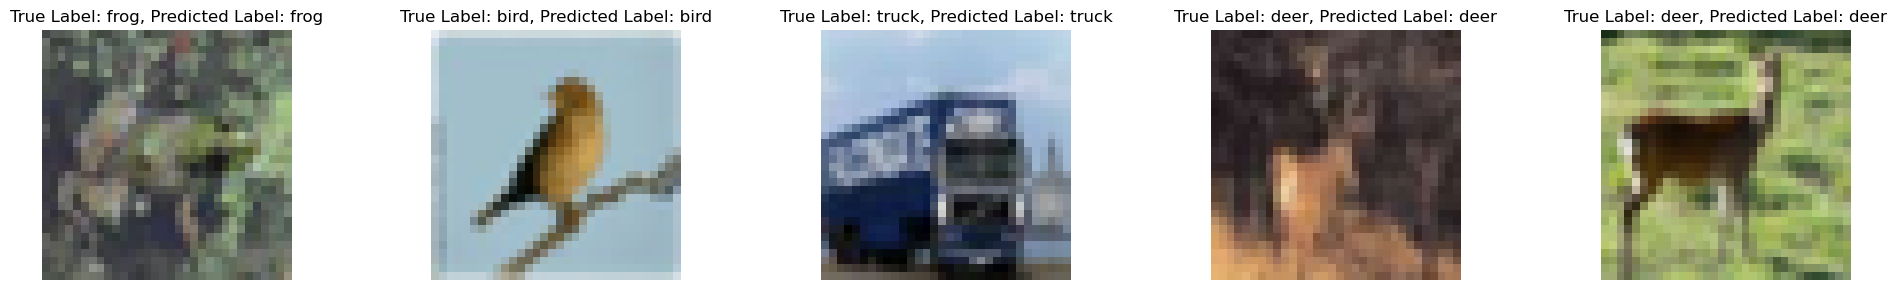

In [22]:
import random
import matplotlib.pyplot as plt
label_list = [ "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse","ship", "truck"]
# 设置要抽取的样本数量
num_samples_to_show = 5

# 随机抽取索引
random_indices = random.sample(range(len(testDataLoader.dataset)),num_samples_to_show)

# 创建一个子图画布，num_samples_to_show列，1行
fig, axs = plt.subplots(1, num_samples_to_show,figsize=(20, 3))  # 调整figsize以适应你的展示需求

# 对每个随机索引的样本进行预测并显示
for idx, ax in zip(random_indices, axs.flat):
    # 获取测试集中的随机样本
    img, true_label = testDataLoader.dataset[idx]
    
    # 将样本移动到设备（GPU或CPU），并准备用于模型预测  
    img = img.unsqueeze(0).to(device)
    imgC = img.cpu()
    
    img_unnormalized = reverse_normalize(imgC, mean, std)
    
    img_unnormalized=img_unnormalized.squeeze(0)
    # 使用模型进行预测
    with torch.no_grad():
        output = myAlexNet(img)

    # 获取预测类别
    predicted_label = torch.argmax(output, dim=1).item()

    # 显示原始图像到对应的子图
    ax.imshow(img_unnormalized.permute(1, 2, 0))  # 如果img是CHW格式，则需 permute(1, 2, 0) 转换为HWC格式
    ax.set_title(f"True Label: {label_list[true_label]}, Predicted Label: {label_list[predicted_label]}")
    ax.axis('off')  # 关闭坐标轴显示，使图像更整洁

# 显示画布
plt.tight_layout()  # 自动调整子图间距
plt.show()

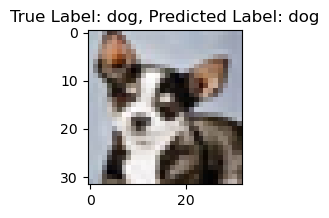

In [113]:
label_list = [
    "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse",
    "ship", "truck"
]

# 首先，定义一个函数来加载和预处理图像
def preprocess_image(image, image_size):
    # 定义转换器来将图像大小调整为所需的大小，并将其转换为PyTorch张量
    preprocess = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        #transforms.RandomHorizontalFlip(),
        #transforms.RandomGrayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    # 应用转换器到图像
    img = preprocess(image)
    # 返回处理后的图像
    return img

image_path = "../data/CatAndDog/dog.png"
image_size = 32

# 读取图片，这里假设图片是彩色的
img_bgr = cv2.imread(image_path)
# 从BGR色彩空间转换为RGB，以便PIL处理
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_pil = Image.fromarray(img_rgb)
# 对图像进行预处理
img_preprocessed = preprocess_image(img_pil, image_size)
# 添加批量维度并将其移到设备上
img_input = img_preprocessed.unsqueeze(0).to(device)

# 使用模型进行预测
with torch.no_grad():
    output = myAlexNet(img_input)

# 获取预测类别
predicted_label = torch.argmax(output, dim=1).item()

plt.figure(figsize=(2, 2))
plt.imshow(img_pil)
plt.title(f"True Label: dog, Predicted Label: {label_list[predicted_label]}")
plt.show()

## ResNet

### 网络定义

In [23]:
#18/34
class BasicBlock(nn.Module):
    expansion = 1  #每一个卷积核的倍数
    def __init__(self,in_channel,out_channel,stride=1,downsample=None):
        super(BasicBlock,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channel,out_channels=out_channel,kernel_size=3,stride=stride,padding=1,bias=False)
        
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.relu = nn.ReLU()
        
        self.conv2 = nn.Conv2d(in_channels=out_channel,out_channels=out_channel,kernel_size=3,stride=1,padding=1,bias=False)
        self.bn2 = nn.BatchNorm2d(out_channel)
        
        self.downsample = downsample
        
    def forward(self,x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)
            
        out =  self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        out += identity
        out =  self.relu(out)
        
        return out
    
class Bottleneck(nn.Module):
    expansion = 4#4倍

    def __init__(self, in_channel, out_channel, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=out_channel,
                               kernel_size=1, stride=1, bias=False)  # squeeze channels
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.relu = nn.ReLU(inplace=True)
        # -----------------------------------------
        self.conv2 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel,
                               kernel_size=3, stride=stride, bias=False, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channel)
        self.relu = nn.ReLU(inplace=True)
        # -----------------------------------------
        self.conv3 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel*self.expansion,#输出*4
                               kernel_size=1, stride=1, bias=False)  # unsqueeze channels
        self.bn3 = nn.BatchNorm2d(out_channel*self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out += identity
        out = self.relu(out)

        return out
    
class ResNet(nn.Module):

    def __init__(self, block, blocks_num, num_classes=1000, include_top=True,datachannels=3):
        #block残差结构 include_top为了之后搭建更加复杂的网络
        super(ResNet, self).__init__()
        self.include_top = include_top
        self.in_channel = 64
    
        self.conv1 = nn.Conv2d(datachannels, self.in_channel, kernel_size=7, stride=2,
                               padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channel)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, blocks_num[0])
        self.layer2 = self._make_layer(block, 128, blocks_num[1], stride=2)
        self.layer3 = self._make_layer(block, 256, blocks_num[2], stride=2)
        self.layer4 = self._make_layer(block, 512, blocks_num[3], stride=2)
        self.flatten = nn.Flatten()
        if self.include_top:
            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # output size = (1, 1)自适应
            self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def _make_layer(self, block, channel, block_num, stride=1):
        downsample = None
        if stride != 1 or self.in_channel != channel * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channel, channel * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(channel * block.expansion))

        layers = []
        layers.append(block(self.in_channel, channel, downsample=downsample, stride=stride))
        self.in_channel = channel * block.expansion

        for _ in range(1, block_num):
            layers.append(block(self.in_channel, channel))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        if self.include_top:
            # x = self.avgpool(x)
            x = self.flatten(x)
            x = self.fc(x)

        return x
    
def resnet18(num_classes=1000, include_top=True,datachannels=3):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes, include_top=include_top,datachannels=datachannels)
    
def resnet34(num_classes=1000, include_top=True,datachannels=3):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes=num_classes, include_top=include_top,datachannels=datachannels)

def resnet34(num_classes=1000, include_top=True,datachannels=3):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes=num_classes, include_top=include_top,datachannels=datachannels)

def resnet101(num_classes=1000, include_top=True,datachannels=3):
    return ResNet(Bottleneck, [3, 4, 23, 3], num_classes=num_classes, include_top=include_top,datachannels=datachannels)

def resnet153(num_classes=1000, include_top=True,datachannels=3):
    return ResNet(Bottleneck, [3, 8, 36, 3], num_classes=num_classes, include_top=include_top,datachannels=datachannels)

### 定于超参数/损失函数/优化器

In [24]:
#定义超参数
#input_size = 28 * 28  #输入大小
#hidden_size = 512 #隐藏层大小
num_classes = 10 #输出大小（类别数）
batch_size = 256 #批大小
learning_rate = 0.001 #学习率
num_epochs = 10 #训练轮数
NUM_EPOCHS = 10

In [25]:
MyResNet101 = resnet101(num_classes=num_classes).to(device)
MyResNet18 = resnet18(num_classes=num_classes).to(device)

In [27]:
loss_function = nn.CrossEntropyLoss()
optimizer18 = optim.Adam(MyResNet18.parameters(), lr=0.0001)
optimizer101 = optim.Adam(MyResNet101.parameters(), lr=0.0001)

### 数据处理

In [28]:
#数据处理
#构建数据集和测试集的DataLoader
trainDataLoader = DataLoader(dataset = train_dataset,
                             batch_size = batch_size,
                             shuffle = True
                             )
testDataLoader = DataLoader(dataset = eval_dataset,batch_size = batch_size,shuffle = True)

# trainDataLoader.to(device)
# testDataLoader.to(device)

Batch Images Shape: torch.Size([256, 3, 32, 32])
Batch Labels: tensor([2, 7, 2, 0, 6])


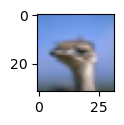

In [29]:
import numpy as np

# 假设你的transform_train包含 Normalize(mean, std)，这里是逆转这部分操作
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])

def reverse_normalize(images, mean, std):
    """逆向Normalize操作，确保正确广播均值和标准差"""
    # 确保mean和std可以广播到images的形状上
    mean_broadcast = mean.reshape(1, -1, 1, 1)  # 形状变为(1,3,1,1)以便于广播
    std_broadcast = std.reshape(1, -1, 1, 1)   # 同理
    return images * std_broadcast + mean_broadcast

# 在显示图像前，先逆向Normalize操作
for images, labels in trainDataLoader:
    print(f"Batch Images Shape: {images.shape}")
    print(f"Batch Labels: {labels[:5]}")  # 只显示前5个标签
    # 转换为numpy数组以便在numpy中操作
    images_np = images.numpy()
    # 逆向Normalize
    original_images = reverse_normalize(images_np, mean, std)
    # 显示第一张图像
    plt.figure(figsize=(1, 1))
    plt.imshow(original_images[0].transpose(1, 2, 0))  # 注意，这里可能需要调整通道顺序以匹配matplotlib的期望
    plt.show()
    break  # 只显示一个批次的数据后跳出循环

### 模型训练

#### 计算TOP-K准确率

In [30]:
# Helper function to calculate top-k accuracy
def top_k_accuracy(output, target, k=5):
    with torch.no_grad():
        max_k = max((1, k))
        batch_size = target.size(0)

        _, pred = output.topk(max_k, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in (1, k):
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

#### ResNet18

In [31]:
print(MyResNet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(64, 

##### 测试训练

In [33]:
MyResNet18.train()
for batch_idx, (trainImgs, labels) in enumerate(trainDataLoader):
    trainImgs = trainImgs.to(device)
    labels = labels.to(device)

    outputs = MyResNet18(trainImgs)
    ##测试函数
    print(f"Outputs data type: {outputs.dtype}")
    print(f"Labels data type: {labels.dtype}")
    print(f"Output shape: {outputs.shape}")
    print(f"Labels shape: {labels.shape}")
    if outputs.device == labels.device:
        print("模型的输出和标签在同一个设备上")
    else:
        print("模型的输出和标签不在同一个设备上，请将它们移动到相同的设备上")
    ##
    loss = loss_function(outputs, labels)
    optimizer18.zero_grad()
    loss.backward()
    optimizer.step()
    
    print(f"Training Loss at batch index {batch_idx}: {loss.item():.4f}")
    break

Outputs data type: torch.float32
Labels data type: torch.int64
Output shape: torch.Size([256, 10])
Labels shape: torch.Size([256])
模型的输出和标签在同一个设备上
Training Loss at batch index 0: 2.5372


##### 正式训练

In [34]:
# 初始化空列表用于存储历史数据
train_loss = []
train_accuracy_top1 = []
train_accuracy_top5 = []
train_epoch_loss = []
train_epoch_accuracy_top1 = []
train_epoch_accuracy_top5 = []

test_loss = []
test_accuracy_top1 = []
test_accuracy_top5 = []

def train(dataloader, model, lossF, optimizer, num_epochs, test_dataloader):
    for epoch in range(num_epochs):
        sum_loss = 0.0
        sum_correct_top1 = 0.0
        sum_correct_top5 = 0.0
        total_samples = 0.0
        model.train()
        processBar = tqdm(dataloader, unit='step')
        for batch, (trainImgs, labels) in enumerate(processBar):
            trainImgs, labels = trainImgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(trainImgs)
            loss = lossF(outputs, labels)

            
            top1_acc, top5_acc = top_k_accuracy(outputs, labels, k=5)
            
            train_loss.append(loss.item())
            train_accuracy_top1.append(top1_acc.item())
            train_accuracy_top5.append(top5_acc.item())
            
            predictions = torch.argmax(outputs, dim=1)
            correct = torch.sum(predictions == labels).item()
            accuracy = correct / labels.size(0)
            
#             train_loss.append(loss)  # 假设epoch_loss_value是你计算得到的当前epoch的训练损失
#             train_accuracy.append(accuracy)  # 假设epoch_accuracy_value是你计算得到的当前epoch的训练精度
            
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()
            sum_correct_top1 += top1_acc.item()
            sum_correct_top5 += top5_acc.item()
            total_samples += labels.size(0)
    
            processBar.set_description(f"Epoch: {epoch+1}/{num_epochs} ; Loss: {loss.item():.4f} Top-1 Acc: {top1_acc.item():.4f}% Top-5 Acc: {top5_acc.item():.4f}%")

        avg_epoch_loss = sum_loss / len(dataloader)
        avg_epoch_accuracy_top1 = sum_correct_top1 / len(dataloader)
        avg_epoch_accuracy_top5 = sum_correct_top5 / len(dataloader)
        train_epoch_loss.append(avg_epoch_loss)
        train_epoch_accuracy_top1.append(avg_epoch_accuracy_top1)
        train_epoch_accuracy_top5.append(avg_epoch_accuracy_top5)
        print(f"Epoch {epoch+1} - Average training loss: {avg_epoch_loss:.4f}, Top-1 Accuracy: {avg_epoch_accuracy_top1:.4f}%, Top-5 Accuracy: {avg_epoch_accuracy_top5:.4f}%")

        # 每个epoch结束后，进行一次测试
        model.eval()
        with torch.no_grad():
            test_acc_top1, test_acc_top5, test_l = test(test_dataloader, model, lossF)
            test_loss.append(test_l)
            test_accuracy_top1.append(test_acc_top1)
            test_accuracy_top5.append(test_acc_top5)
            print(f"Epoch {epoch+1} - Test Top-1 accuracy: {test_acc_top1:.4f}%, Test Top-5 accuracy: {test_acc_top5:.4f}%, Test loss: {test_l:.4f}")

def test(dataloader, model, lossF):
    sum_loss = 0.0
    sum_correct_top1 = 0.0
    sum_correct_top5 = 0.0
    total_samples = 0.0
    for batch, (testImgs, labels) in enumerate(dataloader):
        testImgs, labels = testImgs.to(device), labels.to(device)
        outputs = model(testImgs)
        loss = lossF(outputs, labels)

        top1_acc, top5_acc = top_k_accuracy(outputs, labels, k=5)

        sum_loss += loss.item()
        sum_correct_top1 += top1_acc.item()
        sum_correct_top5 += top5_acc.item()
        total_samples += labels.size(0)

    avg_loss = sum_loss / len(dataloader)
    avg_accuracy_top1 = sum_correct_top1 / len(dataloader)
    avg_accuracy_top5 = sum_correct_top5 / len(dataloader)

    return avg_accuracy_top1, avg_accuracy_top5, avg_loss

# 开始训练
num_epochs = 10
train(trainDataLoader, MyResNet18, loss_function, optimizer18, num_epochs, testDataLoader)

  0%|          | 0/196 [00:00<?, ?step/s]

/home/yuan/miniconda3/envs/pych/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1 - Average training loss: 1.6406, Top-1 Accuracy: 40.4432%, Top-5 Accuracy: 87.3677%
Epoch 1 - Test Top-1 accuracy: 50.1953%, Test Top-5 accuracy: 93.1934%, Test loss: 1.3789


/home/yuan/miniconda3/envs/pych/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


  0%|          | 0/196 [00:00<?, ?step/s]

Epoch 2 - Average training loss: 1.2838, Top-1 Accuracy: 53.9537%, Top-5 Accuracy: 94.1992%
Epoch 2 - Test Top-1 accuracy: 54.7656%, Test Top-5 accuracy: 94.2969%, Test loss: 1.2569


  0%|          | 0/196 [00:00<?, ?step/s]

Epoch 3 - Average training loss: 1.1209, Top-1 Accuracy: 60.1670%, Top-5 Accuracy: 95.6493%
Epoch 3 - Test Top-1 accuracy: 58.0469%, Test Top-5 accuracy: 95.4199%, Test loss: 1.1870


  0%|          | 0/196 [00:00<?, ?step/s]

Epoch 4 - Average training loss: 0.9905, Top-1 Accuracy: 65.1762%, Top-5 Accuracy: 96.7024%
Epoch 4 - Test Top-1 accuracy: 59.7754%, Test Top-5 accuracy: 95.8203%, Test loss: 1.1475


  0%|          | 0/196 [00:00<?, ?step/s]

Epoch 5 - Average training loss: 0.8879, Top-1 Accuracy: 69.0087%, Top-5 Accuracy: 97.4099%
Epoch 5 - Test Top-1 accuracy: 61.0645%, Test Top-5 accuracy: 96.0645%, Test loss: 1.1103


  0%|          | 0/196 [00:00<?, ?step/s]

Epoch 6 - Average training loss: 0.7915, Top-1 Accuracy: 72.6299%, Top-5 Accuracy: 97.9185%
Epoch 6 - Test Top-1 accuracy: 61.7090%, Test Top-5 accuracy: 95.9766%, Test loss: 1.1037


  0%|          | 0/196 [00:00<?, ?step/s]

Epoch 7 - Average training loss: 0.7003, Top-1 Accuracy: 75.8685%, Top-5 Accuracy: 98.4893%
Epoch 7 - Test Top-1 accuracy: 61.6113%, Test Top-5 accuracy: 96.0156%, Test loss: 1.1338


  0%|          | 0/196 [00:00<?, ?step/s]

Epoch 8 - Average training loss: 0.6192, Top-1 Accuracy: 79.1287%, Top-5 Accuracy: 98.8138%
Epoch 8 - Test Top-1 accuracy: 62.4414%, Test Top-5 accuracy: 96.0938%, Test loss: 1.1540


  0%|          | 0/196 [00:00<?, ?step/s]

Epoch 9 - Average training loss: 0.5472, Top-1 Accuracy: 81.7765%, Top-5 Accuracy: 98.9553%
Epoch 9 - Test Top-1 accuracy: 62.2754%, Test Top-5 accuracy: 96.0840%, Test loss: 1.1877


  0%|          | 0/196 [00:00<?, ?step/s]

Epoch 10 - Average training loss: 0.4810, Top-1 Accuracy: 84.0366%, Top-5 Accuracy: 99.2662%
Epoch 10 - Test Top-1 accuracy: 62.5391%, Test Top-5 accuracy: 95.6836%, Test loss: 1.2203


##### 模型可视化

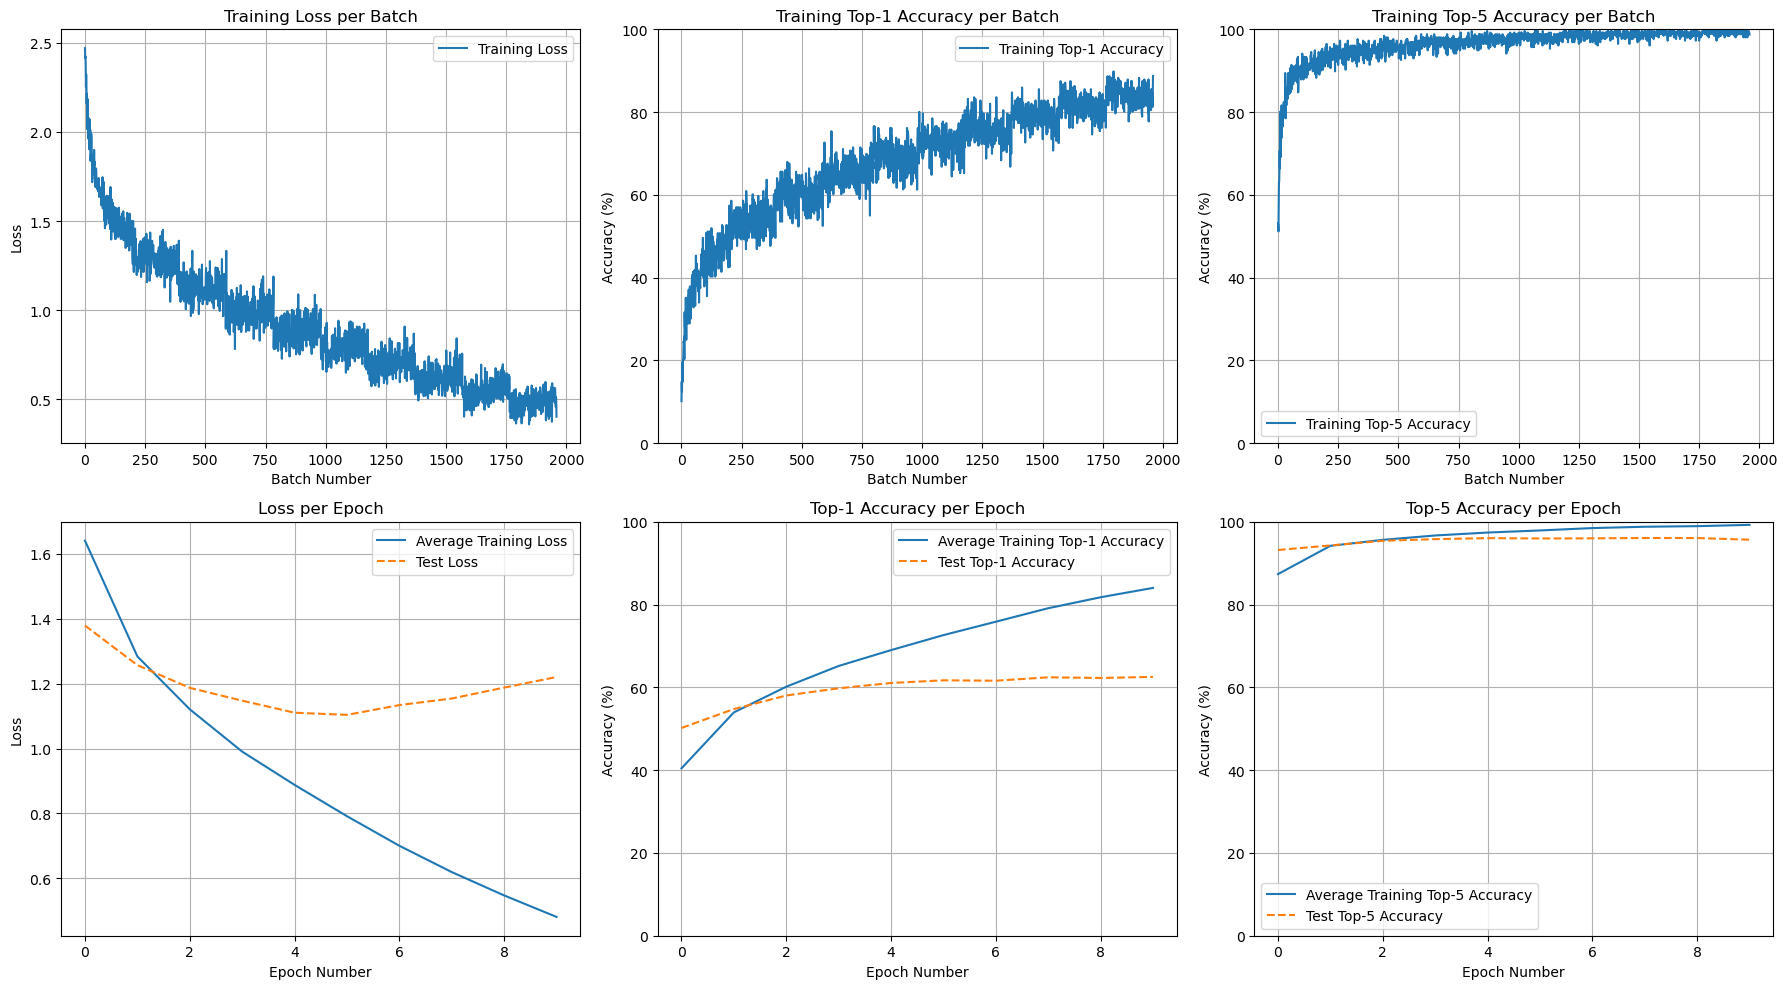

In [35]:
# 可视化代码
import numpy as np
import matplotlib.pyplot as plt

# 确保转换回CPU并转换成numpy数组
train_loss = np.array(train_loss)
train_accuracy_top1 = np.array(train_accuracy_top1)
train_accuracy_top5 = np.array(train_accuracy_top5)
train_epoch_loss = np.array(train_epoch_loss)
train_epoch_accuracy_top1 = np.array(train_epoch_accuracy_top1)
train_epoch_accuracy_top5 = np.array(train_epoch_accuracy_top5)

test_loss = np.array(test_loss)
test_accuracy_top1 = np.array(test_accuracy_top1)
test_accuracy_top5 = np.array(test_accuracy_top5)

plt.figure(figsize=(18, 10))

# 绘制训练损失曲线
plt.subplot(2, 3, 1)
plt.plot(range(len(train_loss)), train_loss, label='Training Loss')
plt.title('Training Loss per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# 绘制训练Top-1准确率曲线
plt.subplot(2, 3, 2)
plt.plot(range(len(train_accuracy_top1)), train_accuracy_top1, label='Training Top-1 Accuracy')
plt.title('Training Top-1 Accuracy per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Accuracy (%)')
plt.ylim([0, 100])
plt.grid(True)
plt.legend()

# 绘制训练Top-5准确率曲线
plt.subplot(2, 3, 3)
plt.plot(range(len(train_accuracy_top5)), train_accuracy_top5, label='Training Top-5 Accuracy')
plt.title('Training Top-5 Accuracy per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Accuracy (%)')
plt.ylim([0, 100])
plt.grid(True)
plt.legend()

# 绘制每个epoch的平均训练损失曲线
plt.subplot(2, 3, 4)
plt.plot(range(len(train_epoch_loss)), train_epoch_loss, label='Average Training Loss')
plt.plot(range(len(test_loss)), test_loss, label='Test Loss', linestyle='--')
plt.title('Loss per Epoch')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# 绘制每个epoch的平均训练Top-1准确率曲线
plt.subplot(2, 3, 5)
plt.plot(range(len(train_epoch_accuracy_top1)), train_epoch_accuracy_top1, label='Average Training Top-1 Accuracy')
plt.plot(range(len(test_accuracy_top1)), test_accuracy_top1, label='Test Top-1 Accuracy', linestyle='--')
plt.title('Top-1 Accuracy per Epoch')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy (%)')
plt.ylim([0, 100])
plt.grid(True)
plt.legend()

# 绘制每个epoch的平均训练Top-5准确率曲线
plt.subplot(2, 3, 6)
plt.plot(range(len(train_epoch_accuracy_top5)), train_epoch_accuracy_top5, label='Average Training Top-5 Accuracy')
plt.plot(range(len(test_accuracy_top5)), test_accuracy_top5, label='Test Top-5 Accuracy', linestyle='--')
plt.title('Top-5 Accuracy per Epoch')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy (%)')
plt.ylim([0, 100])
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

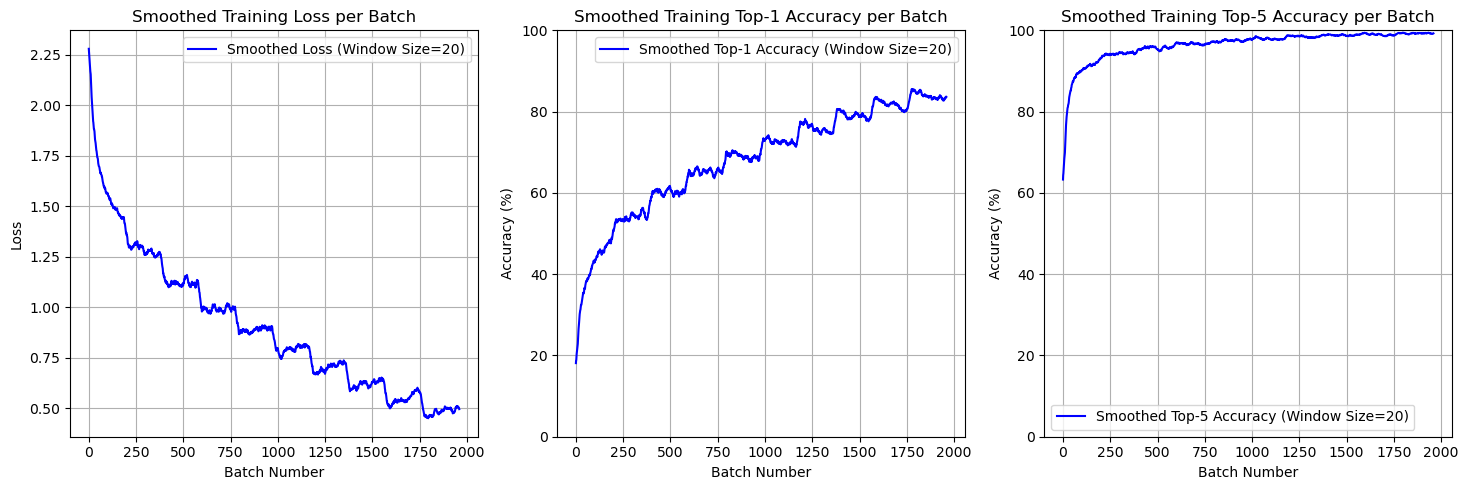

In [36]:
def smooth_curve(points, window_size):
    """
    对数据点进行移动平均平滑处理。
    :param points: 原始数据点列表
    :param window_size: 平滑窗口的大小
    :return: 平滑后的数据点列表
    """
    if window_size < 2:
        return points
    
    smoothed_points = []
    for idx in range(len(points)):
        start = max(0, idx - window_size//2)
        end = min(len(points), idx + window_size//2 + 1)
        window = points[start:end]
        avg = sum(window) / len(window)
        smoothed_points.append(avg)
    
    return smoothed_points

# 平滑数据
window_size = 20
smoothed_train_loss = smooth_curve(train_loss, window_size)
smoothed_train_accuracy_top1 = smooth_curve(train_accuracy_top1, window_size)
smoothed_train_accuracy_top5 = smooth_curve(train_accuracy_top5, window_size)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(smoothed_train_loss, label=f'Smoothed Loss (Window Size={window_size})', color='blue')
plt.title('Smoothed Training Loss per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# 绘制平滑后的训练Top-1准确率曲线
plt.subplot(1, 3, 2)
plt.plot(smoothed_train_accuracy_top1, label=f'Smoothed Top-1 Accuracy (Window Size={window_size})', color='blue')
plt.title('Smoothed Training Top-1 Accuracy per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Accuracy (%)')
plt.ylim([0, 100])
plt.grid(True)
plt.legend()

# 绘制平滑后的训练Top-5准确率曲线
plt.subplot(1, 3, 3)
plt.plot(smoothed_train_accuracy_top5, label=f'Smoothed Top-5 Accuracy (Window Size={window_size})', color='blue')
plt.title('Smoothed Training Top-5 Accuracy per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Accuracy (%)')
plt.ylim([0, 100])
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

#### 预测示例

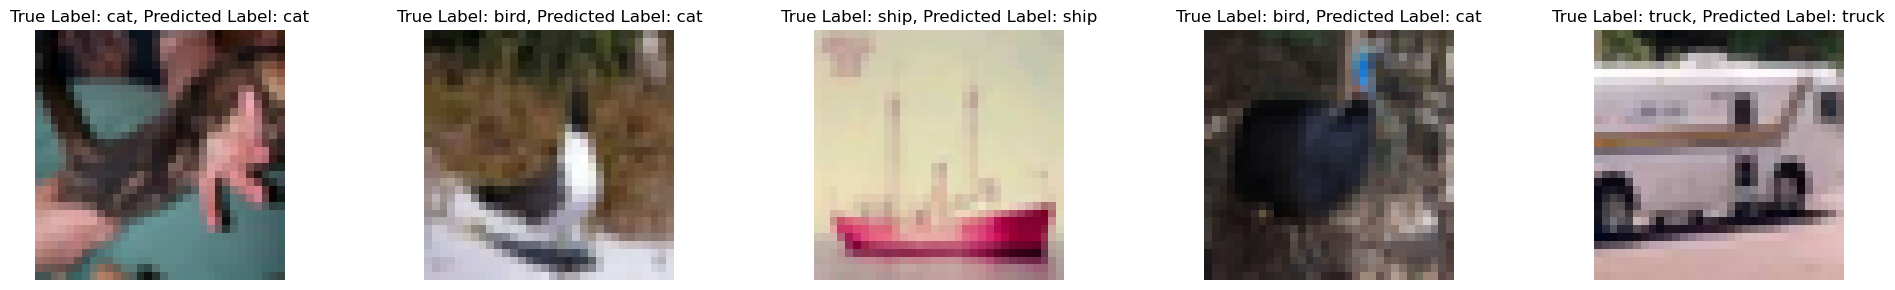

In [40]:
import random
import matplotlib.pyplot as plt

label_list = [ "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse","ship", "truck"]
# 设置要抽取的样本数量
num_samples_to_show = 5

# 随机抽取索引
random_indices = random.sample(range(len(testDataLoader.dataset)),num_samples_to_show)

# 创建一个子图画布，num_samples_to_show列，1行
fig, axs = plt.subplots(1, num_samples_to_show,figsize=(20, 3))  # 调整figsize以适应你的展示需求

# 对每个随机索引的样本进行预测并显示
for idx, ax in zip(random_indices, axs.flat):
    # 获取测试集中的随机样本
    img, true_label = testDataLoader.dataset[idx]
    
    # 将样本移动到设备（GPU或CPU），并准备用于模型预测  
    img = img.unsqueeze(0).to(device)
    imgC = img.cpu()
    
    img_unnormalized = reverse_normalize(imgC, mean, std)
    
    img_unnormalized=img_unnormalized.squeeze(0)
    # 使用模型进行预测
    with torch.no_grad():
        output = MyResNet18(img)

    # 获取预测类别
    predicted_label = torch.argmax(output, dim=1).item()

    # 显示原始图像到对应的子图
    ax.imshow(img_unnormalized.permute(1, 2, 0))  # 如果img是CHW格式，则需 permute(1, 2, 0) 转换为HWC格式
    ax.set_title(f"True Label: {label_list[true_label]}, Predicted Label: {label_list[predicted_label]}")
    ax.axis('off')  # 关闭坐标轴显示，使图像更整洁

# 显示画布
plt.tight_layout()  # 自动调整子图间距
plt.show()

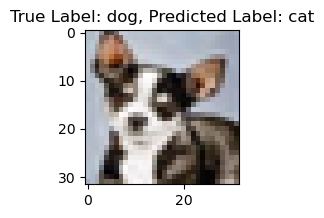

In [108]:
label_list = [
    "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse",
    "ship", "truck"
]

# 首先，定义一个函数来加载和预处理图像
def preprocess_image(image, image_size):
    # 定义转换器来将图像大小调整为所需的大小，并将其转换为PyTorch张量
    preprocess = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomGrayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    # 应用转换器到图像
    img = preprocess(image)
    # 返回处理后的图像
    return img

image_path = "../data/CatAndDog/dog.png"
image_size = 32

# 读取图片，这里假设图片是彩色的
img_bgr = cv2.imread(image_path)
# 从BGR色彩空间转换为RGB，以便PIL处理
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_pil = Image.fromarray(img_rgb)
# 对图像进行预处理
img_preprocessed = preprocess_image(img_pil, image_size)
# 添加批量维度并将其移到设备上
img_input = img_preprocessed.unsqueeze(0).to(device)

# 使用模型进行预测
with torch.no_grad():
    output = MyResNet101(img_input)

# 获取预测类别
predicted_label = torch.argmax(output, dim=1).item()

plt.figure(figsize=(2, 2))
plt.imshow(img_pil)
plt.title(f"True Label: dog, Predicted Label: {label_list[predicted_label]}")
plt.show()

#### ResNet101

In [42]:
MyResNet101.train()
for batch_idx, (trainImgs, labels) in enumerate(trainDataLoader):
    trainImgs = trainImgs.to(device)
    labels = labels.to(device)

    outputs = MyResNet101(trainImgs)
    ##测试函数
    print(f"Outputs data type: {outputs.dtype}")
    print(f"Labels data type: {labels.dtype}")
    print(f"Output shape: {outputs.shape}")
    print(f"Labels shape: {labels.shape}")
    if outputs.device == labels.device:
        print("模型的输出和标签在同一个设备上")
    else:
        print("模型的输出和标签不在同一个设备上，请将它们移动到相同的设备上")
    ##
    loss = loss_function(outputs, labels)
    optimizer101.zero_grad()
    loss.backward()
    optimizer.step()
    
    print(f"Training Loss at batch index {batch_idx}: {loss.item():.4f}")
    break

Outputs data type: torch.float32
Labels data type: torch.int64
Output shape: torch.Size([256, 10])
Labels shape: torch.Size([256])
模型的输出和标签在同一个设备上
Training Loss at batch index 0: 2.4646


In [44]:
# 初始化空列表用于存储历史数据
train_loss = []
train_accuracy_top1 = []
train_accuracy_top5 = []
train_epoch_loss = []
train_epoch_accuracy_top1 = []
train_epoch_accuracy_top5 = []

test_loss = []
test_accuracy_top1 = []
test_accuracy_top5 = []

def train(dataloader, model, lossF, optimizer, num_epochs, test_dataloader):
    for epoch in range(num_epochs):
        sum_loss = 0.0
        sum_correct_top1 = 0.0
        sum_correct_top5 = 0.0
        total_samples = 0.0
        model.train()
        processBar = tqdm(dataloader, unit='step')
        for batch, (trainImgs, labels) in enumerate(processBar):
            trainImgs, labels = trainImgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(trainImgs)
            loss = lossF(outputs, labels)

            
            top1_acc, top5_acc = top_k_accuracy(outputs, labels, k=5)
            
            train_loss.append(loss.item())
            train_accuracy_top1.append(top1_acc.item())
            train_accuracy_top5.append(top5_acc.item())
            
            predictions = torch.argmax(outputs, dim=1)
            correct = torch.sum(predictions == labels).item()
            accuracy = correct / labels.size(0)
            
#             train_loss.append(loss)  # 假设epoch_loss_value是你计算得到的当前epoch的训练损失
#             train_accuracy.append(accuracy)  # 假设epoch_accuracy_value是你计算得到的当前epoch的训练精度
            
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()
            sum_correct_top1 += top1_acc.item()
            sum_correct_top5 += top5_acc.item()
            total_samples += labels.size(0)
    
            processBar.set_description(f"Epoch: {epoch+1}/{num_epochs} ; Loss: {loss.item():.4f} Top-1 Acc: {top1_acc.item():.4f}% Top-5 Acc: {top5_acc.item():.4f}%")

        avg_epoch_loss = sum_loss / len(dataloader)
        avg_epoch_accuracy_top1 = sum_correct_top1 / len(dataloader)
        avg_epoch_accuracy_top5 = sum_correct_top5 / len(dataloader)
        train_epoch_loss.append(avg_epoch_loss)
        train_epoch_accuracy_top1.append(avg_epoch_accuracy_top1)
        train_epoch_accuracy_top5.append(avg_epoch_accuracy_top5)
        print(f"Epoch {epoch+1} - Average training loss: {avg_epoch_loss:.4f}, Top-1 Accuracy: {avg_epoch_accuracy_top1:.4f}%, Top-5 Accuracy: {avg_epoch_accuracy_top5:.4f}%")

        # 每个epoch结束后，进行一次测试
        model.eval()
        with torch.no_grad():
            test_acc_top1, test_acc_top5, test_l = test(test_dataloader, model, lossF)
            test_loss.append(test_l)
            test_accuracy_top1.append(test_acc_top1)
            test_accuracy_top5.append(test_acc_top5)
            print(f"Epoch {epoch+1} - Test Top-1 accuracy: {test_acc_top1:.4f}%, Test Top-5 accuracy: {test_acc_top5:.4f}%, Test loss: {test_l:.4f}")

def test(dataloader, model, lossF):
    sum_loss = 0.0
    sum_correct_top1 = 0.0
    sum_correct_top5 = 0.0
    total_samples = 0.0
    for batch, (testImgs, labels) in enumerate(dataloader):
        testImgs, labels = testImgs.to(device), labels.to(device)
        outputs = model(testImgs)
        loss = lossF(outputs, labels)

        top1_acc, top5_acc = top_k_accuracy(outputs, labels, k=5)

        sum_loss += loss.item()
        sum_correct_top1 += top1_acc.item()
        sum_correct_top5 += top5_acc.item()
        total_samples += labels.size(0)

    avg_loss = sum_loss / len(dataloader)
    avg_accuracy_top1 = sum_correct_top1 / len(dataloader)
    avg_accuracy_top5 = sum_correct_top5 / len(dataloader)

    return avg_accuracy_top1, avg_accuracy_top5, avg_loss

# 开始训练
num_epochs = 10
train(trainDataLoader, MyResNet101, loss_function, optimizer101, num_epochs, testDataLoader)

  0%|          | 0/196 [00:00<?, ?step/s]

Epoch 1 - Average training loss: 1.9371, Top-1 Accuracy: 28.7464%, Top-5 Accuracy: 80.7370%
Epoch 1 - Test Top-1 accuracy: 31.1816%, Test Top-5 accuracy: 82.9590%, Test loss: 1.8757


  0%|          | 0/196 [00:00<?, ?step/s]

Epoch 2 - Average training loss: 1.8404, Top-1 Accuracy: 32.7268%, Top-5 Accuracy: 83.4080%
Epoch 2 - Test Top-1 accuracy: 34.2188%, Test Top-5 accuracy: 85.0000%, Test loss: 1.8072


  0%|          | 0/196 [00:00<?, ?step/s]

Epoch 3 - Average training loss: 1.7524, Top-1 Accuracy: 36.2851%, Top-5 Accuracy: 85.8510%
Epoch 3 - Test Top-1 accuracy: 37.9004%, Test Top-5 accuracy: 85.8008%, Test loss: 1.7375


  0%|          | 0/196 [00:00<?, ?step/s]

Epoch 4 - Average training loss: 1.6740, Top-1 Accuracy: 39.2279%, Top-5 Accuracy: 87.7914%
Epoch 4 - Test Top-1 accuracy: 39.0039%, Test Top-5 accuracy: 87.6367%, Test loss: 1.7129


  0%|          | 0/196 [00:00<?, ?step/s]

Epoch 5 - Average training loss: 1.6034, Top-1 Accuracy: 41.9073%, Top-5 Accuracy: 89.1243%
Epoch 5 - Test Top-1 accuracy: 41.2305%, Test Top-5 accuracy: 89.1699%, Test loss: 1.6372


  0%|          | 0/196 [00:00<?, ?step/s]

Epoch 6 - Average training loss: 1.5359, Top-1 Accuracy: 44.5137%, Top-5 Accuracy: 90.4365%
Epoch 6 - Test Top-1 accuracy: 43.4863%, Test Top-5 accuracy: 89.6289%, Test loss: 1.5778


  0%|          | 0/196 [00:00<?, ?step/s]

Epoch 7 - Average training loss: 1.4667, Top-1 Accuracy: 47.3597%, Top-5 Accuracy: 91.5330%
Epoch 7 - Test Top-1 accuracy: 43.9746%, Test Top-5 accuracy: 90.3418%, Test loss: 1.5624


  0%|          | 0/196 [00:00<?, ?step/s]

Epoch 8 - Average training loss: 1.4197, Top-1 Accuracy: 49.0737%, Top-5 Accuracy: 92.2242%
Epoch 8 - Test Top-1 accuracy: 45.7129%, Test Top-5 accuracy: 90.6543%, Test loss: 1.5518


  0%|          | 0/196 [00:00<?, ?step/s]

Epoch 9 - Average training loss: 1.3581, Top-1 Accuracy: 51.3971%, Top-5 Accuracy: 92.9919%
Epoch 9 - Test Top-1 accuracy: 45.3711%, Test Top-5 accuracy: 90.9473%, Test loss: 1.5882


  0%|          | 0/196 [00:00<?, ?step/s]

Epoch 10 - Average training loss: 1.3093, Top-1 Accuracy: 53.6930%, Top-5 Accuracy: 93.6683%
Epoch 10 - Test Top-1 accuracy: 47.0605%, Test Top-5 accuracy: 90.8496%, Test loss: 1.5182


##### 模型可视化

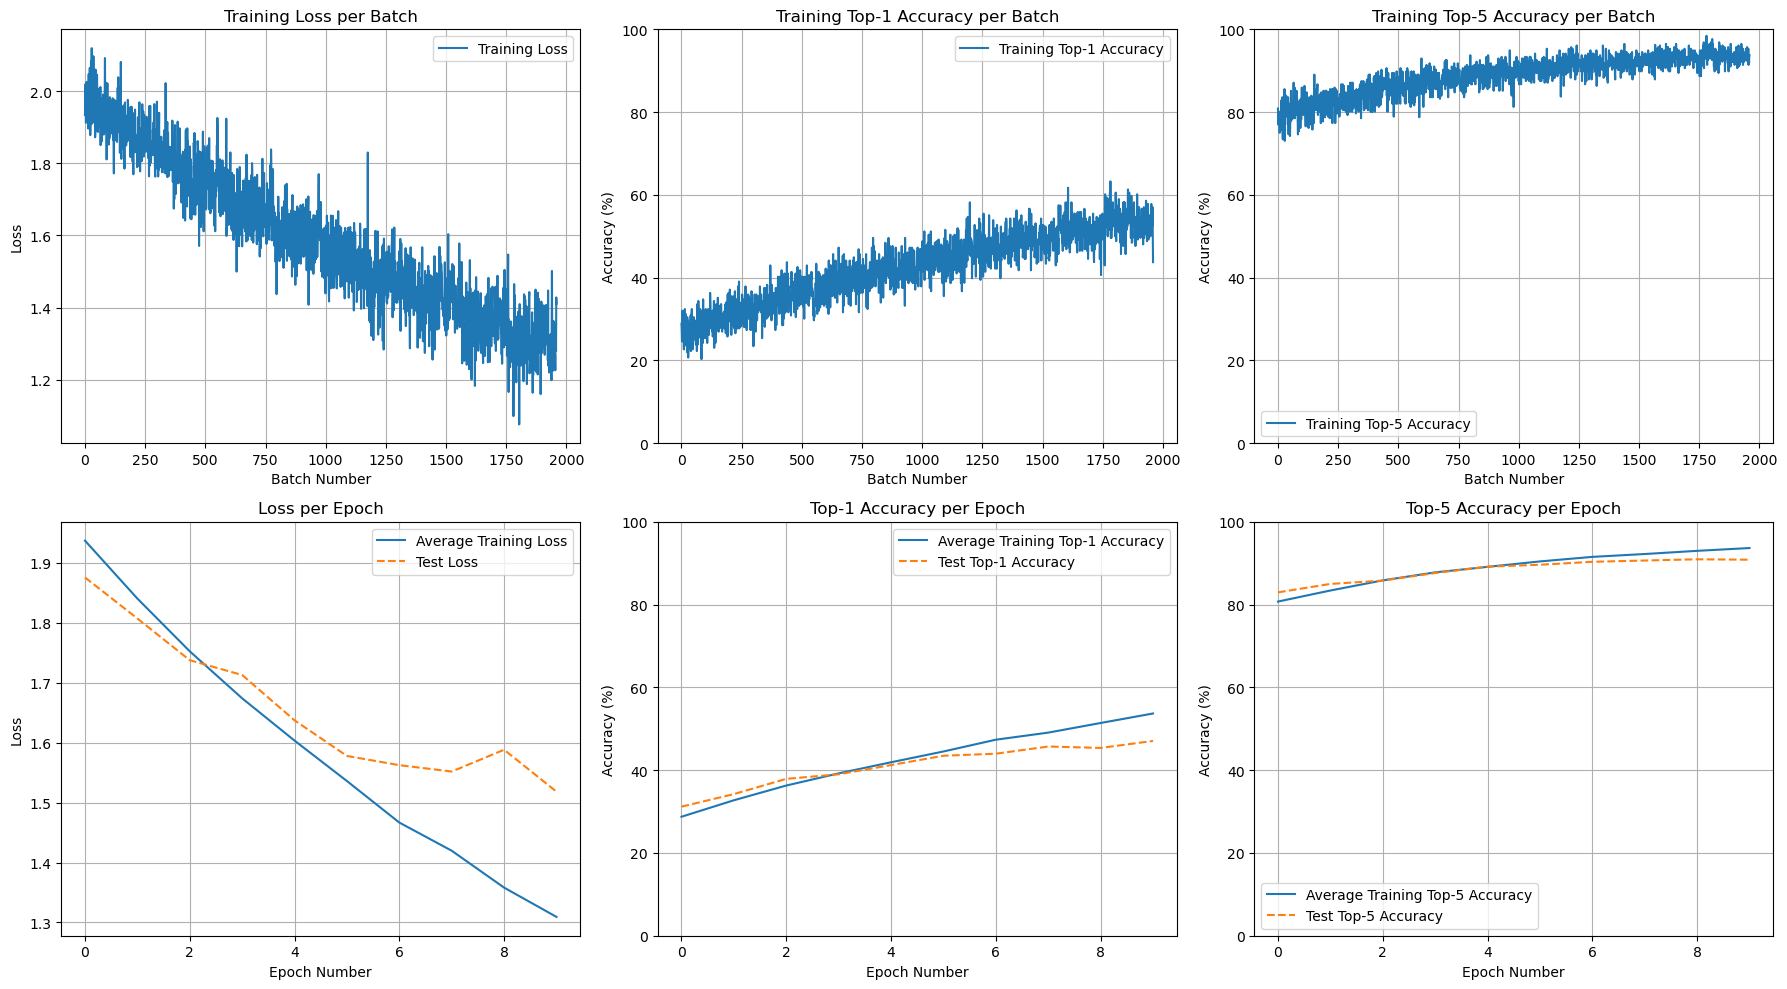

In [45]:
# 可视化代码
import numpy as np
import matplotlib.pyplot as plt

# 确保转换回CPU并转换成numpy数组
train_loss = np.array(train_loss)
train_accuracy_top1 = np.array(train_accuracy_top1)
train_accuracy_top5 = np.array(train_accuracy_top5)
train_epoch_loss = np.array(train_epoch_loss)
train_epoch_accuracy_top1 = np.array(train_epoch_accuracy_top1)
train_epoch_accuracy_top5 = np.array(train_epoch_accuracy_top5)

test_loss = np.array(test_loss)
test_accuracy_top1 = np.array(test_accuracy_top1)
test_accuracy_top5 = np.array(test_accuracy_top5)

plt.figure(figsize=(18, 10))

# 绘制训练损失曲线
plt.subplot(2, 3, 1)
plt.plot(range(len(train_loss)), train_loss, label='Training Loss')
plt.title('Training Loss per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# 绘制训练Top-1准确率曲线
plt.subplot(2, 3, 2)
plt.plot(range(len(train_accuracy_top1)), train_accuracy_top1, label='Training Top-1 Accuracy')
plt.title('Training Top-1 Accuracy per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Accuracy (%)')
plt.ylim([0, 100])
plt.grid(True)
plt.legend()

# 绘制训练Top-5准确率曲线
plt.subplot(2, 3, 3)
plt.plot(range(len(train_accuracy_top5)), train_accuracy_top5, label='Training Top-5 Accuracy')
plt.title('Training Top-5 Accuracy per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Accuracy (%)')
plt.ylim([0, 100])
plt.grid(True)
plt.legend()

# 绘制每个epoch的平均训练损失曲线
plt.subplot(2, 3, 4)
plt.plot(range(len(train_epoch_loss)), train_epoch_loss, label='Average Training Loss')
plt.plot(range(len(test_loss)), test_loss, label='Test Loss', linestyle='--')
plt.title('Loss per Epoch')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# 绘制每个epoch的平均训练Top-1准确率曲线
plt.subplot(2, 3, 5)
plt.plot(range(len(train_epoch_accuracy_top1)), train_epoch_accuracy_top1, label='Average Training Top-1 Accuracy')
plt.plot(range(len(test_accuracy_top1)), test_accuracy_top1, label='Test Top-1 Accuracy', linestyle='--')
plt.title('Top-1 Accuracy per Epoch')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy (%)')
plt.ylim([0, 100])
plt.grid(True)
plt.legend()

# 绘制每个epoch的平均训练Top-5准确率曲线
plt.subplot(2, 3, 6)
plt.plot(range(len(train_epoch_accuracy_top5)), train_epoch_accuracy_top5, label='Average Training Top-5 Accuracy')
plt.plot(range(len(test_accuracy_top5)), test_accuracy_top5, label='Test Top-5 Accuracy', linestyle='--')
plt.title('Top-5 Accuracy per Epoch')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy (%)')
plt.ylim([0, 100])
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

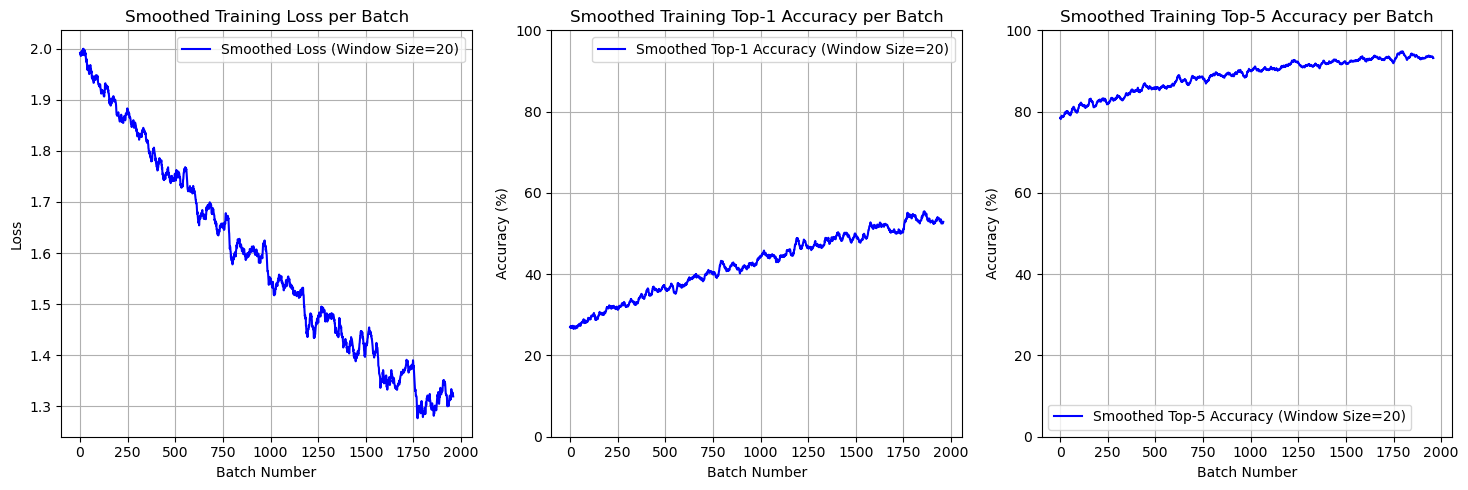

In [46]:
def smooth_curve(points, window_size):
    """
    对数据点进行移动平均平滑处理。
    :param points: 原始数据点列表
    :param window_size: 平滑窗口的大小
    :return: 平滑后的数据点列表
    """
    if window_size < 2:
        return points
    
    smoothed_points = []
    for idx in range(len(points)):
        start = max(0, idx - window_size//2)
        end = min(len(points), idx + window_size//2 + 1)
        window = points[start:end]
        avg = sum(window) / len(window)
        smoothed_points.append(avg)
    
    return smoothed_points

# 平滑数据
window_size = 20
smoothed_train_loss = smooth_curve(train_loss, window_size)
smoothed_train_accuracy_top1 = smooth_curve(train_accuracy_top1, window_size)
smoothed_train_accuracy_top5 = smooth_curve(train_accuracy_top5, window_size)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(smoothed_train_loss, label=f'Smoothed Loss (Window Size={window_size})', color='blue')
plt.title('Smoothed Training Loss per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# 绘制平滑后的训练Top-1准确率曲线
plt.subplot(1, 3, 2)
plt.plot(smoothed_train_accuracy_top1, label=f'Smoothed Top-1 Accuracy (Window Size={window_size})', color='blue')
plt.title('Smoothed Training Top-1 Accuracy per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Accuracy (%)')
plt.ylim([0, 100])
plt.grid(True)
plt.legend()

# 绘制平滑后的训练Top-5准确率曲线
plt.subplot(1, 3, 3)
plt.plot(smoothed_train_accuracy_top5, label=f'Smoothed Top-5 Accuracy (Window Size={window_size})', color='blue')
plt.title('Smoothed Training Top-5 Accuracy per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Accuracy (%)')
plt.ylim([0, 100])
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

#### 预测示例

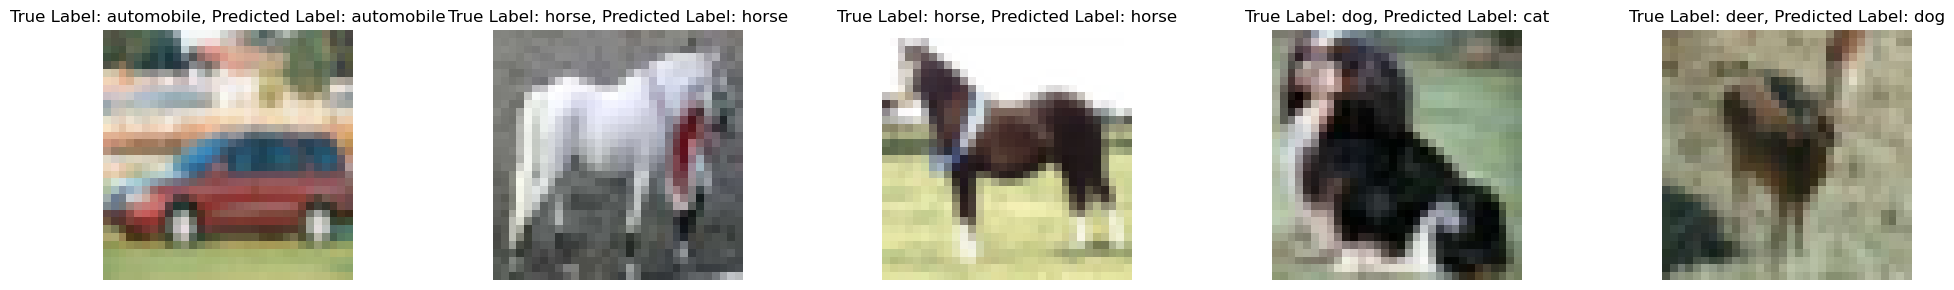

In [47]:
import random
import matplotlib.pyplot as plt

label_list = [ "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse","ship", "truck"]

# 设置要抽取的样本数量
num_samples_to_show = 5

# 随机抽取索引
random_indices = random.sample(range(len(testDataLoader.dataset)),num_samples_to_show)

# 创建一个子图画布，num_samples_to_show列，1行
fig, axs = plt.subplots(1, num_samples_to_show,figsize=(20, 3))  # 调整figsize以适应你的展示需求

# 对每个随机索引的样本进行预测并显示
for idx, ax in zip(random_indices, axs.flat):
    # 获取测试集中的随机样本
    img, true_label = testDataLoader.dataset[idx]
    
    # 将样本移动到设备（GPU或CPU），并准备用于模型预测  
    img = img.unsqueeze(0).to(device)
    imgC = img.cpu()
    
    img_unnormalized = reverse_normalize(imgC, mean, std)
    
    img_unnormalized=img_unnormalized.squeeze(0)
    # 使用模型进行预测
    with torch.no_grad():
        output = MyResNet101(img)

    # 获取预测类别
    predicted_label = torch.argmax(output, dim=1).item()

    # 显示原始图像到对应的子图
    ax.imshow(img_unnormalized.permute(1, 2, 0))  # 如果img是CHW格式，则需 permute(1, 2, 0) 转换为HWC格式
    ax.set_title(f"True Label: {label_list[true_label]}, Predicted Label: {label_list[predicted_label]}")
    ax.axis('off')  # 关闭坐标轴显示，使图像更整洁

# 显示画布
plt.tight_layout()  # 自动调整子图间距
plt.show()

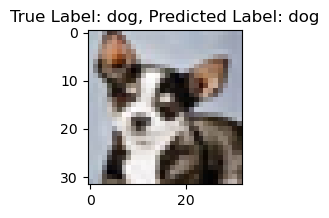

In [112]:
label_list = [
    "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse",
    "ship", "truck"
]

# 首先，定义一个函数来加载和预处理图像
def preprocess_image(image, image_size):
    # 定义转换器来将图像大小调整为所需的大小，并将其转换为PyTorch张量
    preprocess = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomGrayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    # 应用转换器到图像
    img = preprocess(image)
    # 返回处理后的图像
    return img

image_path = "../data/CatAndDog/dog.png"
image_size = 32

# 读取图片，这里假设图片是彩色的
img_bgr = cv2.imread(image_path)
# 从BGR色彩空间转换为RGB，以便PIL处理
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_pil = Image.fromarray(img_rgb)
# 对图像进行预处理
img_preprocessed = preprocess_image(img_pil, image_size)
# 添加批量维度并将其移到设备上
img_input = img_preprocessed.unsqueeze(0).to(device)

# 使用模型进行预测
with torch.no_grad():
    output = MyResNet18(img_input)

# 获取预测类别
predicted_label = torch.argmax(output, dim=1).item()

plt.figure(figsize=(2, 2))
plt.imshow(img_pil)
plt.title(f"True Label: dog, Predicted Label: {label_list[predicted_label]}")
plt.show()

## ViT

**pair函数**  
作用是：判断t是否是元组，如果是，直接返回t；如果不是，则将t复制为元组(t, t)再返回。

In [48]:
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

### 网路结构实现-TransFormer部分

#### PreNorm 归一化

In [49]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

#### FeedForward 前馈神经网络

In [59]:
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim), 
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

#### Attention 多头注意力机制

In [60]:
class Attention(nn.Module):              
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim=-1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout),
        ) if project_out else nn.Identity()

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim=-1)           # (b, n(65), dim*3) ---> 3 * (b, n, dim)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=h), qkv)          # q, k, v   (b, h, n, dim_head(64))

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = self.attend(dots)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

#### TransFormer

In [61]:
class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads=heads, dim_head=dim_head, dropout=dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout=dropout))
            ]))
    
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

### ViT网络结构

In [62]:
class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool='cls', channels=3, dim_head=64, dropout=0., emb_dropout=0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert  image_height % patch_height ==0 and image_width % patch_width == 0

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_height, p2=patch_width),
            nn.Linear(patch_dim, dim)
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches+1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))					# nn.Parameter()定义可学习参数
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)        # b c (h p1) (w p2) -> b (h w) (p1 p2 c) -> b (h w) dim
        b, n, _ = x.shape           # b表示batchSize, n表示每个块的空间分辨率, _表示一个块内有多少个值

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b=b)  # self.cls_token: (1, 1, dim) -> cls_tokens: (batchSize, 1, dim)  
        x = torch.cat((cls_tokens, x), dim=1)               # 将cls_token拼接到patch token中去       (b, 65, dim)
        x += self.pos_embedding[:, :(n+1)]                  # 加位置嵌入（直接加）      (b, 65, dim)
        x = self.dropout(x)

        x = self.transformer(x)                                                 # (b, 65, dim)

        x = x.mean(dim=1) if self.pool == 'mean' else x[:, 0]                   # (b, dim)

        x = self.to_latent(x)                                                   # Identity (b, dim)
        #print(x.shape)

        return self.mlp_head(x)                                                 #  (b, num_classes)

### 定义超参数

In [63]:
#定义超参数
#input_size = 28 * 28  #输入大小
#hidden_size = 512 #隐藏层大小
num_classes = 10 #输出大小（类别数）
batch_size = 256 #批大小
num_epochs = 10 #训练轮数


### 数据处理

In [64]:
#构建数据集和测试集的DataLoader
trainDataLoader = DataLoader(dataset = train_dataset,
                             batch_size = batch_size,
                             shuffle = True
                             )
testDataLoader = DataLoader(dataset = eval_dataset,batch_size = batch_size,shuffle = True)

Batch Images Shape: torch.Size([256, 3, 32, 32])
Batch Labels: tensor([4, 9, 5, 7, 8])


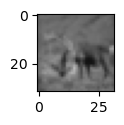

In [65]:
import numpy as np

# 假设你的transform_train包含 Normalize(mean, std)，这里是逆转这部分操作
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])

def reverse_normalize(images, mean, std):
    """逆向Normalize操作，确保正确广播均值和标准差"""
    # 确保mean和std可以广播到images的形状上
    mean_broadcast = mean.reshape(1, -1, 1, 1)  # 形状变为(1,3,1,1)以便于广播
    std_broadcast = std.reshape(1, -1, 1, 1)   # 同理
    return images * std_broadcast + mean_broadcast

# 在显示图像前，先逆向Normalize操作
for images, labels in trainDataLoader:
    print(f"Batch Images Shape: {images.shape}")
    print(f"Batch Labels: {labels[:5]}")  # 只显示前5个标签
    # 转换为numpy数组以便在numpy中操作
    images_np = images.numpy()
    # 逆向Normalize
    original_images = reverse_normalize(images_np, mean, std)
    # 显示第一张图像
    plt.figure(figsize=(1, 1))
    plt.imshow(original_images[0].transpose(1, 2, 0))  # 注意，这里可能需要调整通道顺序以匹配matplotlib的期望
    plt.show()
    break  # 只显示一个批次的数据后跳出循环

### 模型训练

> image_size=32：  
> 解释：输入图像的大小。假设输入的图像是32x32像素。    

> patch_size=7：
> - 解释：图像被分割成的块的大小。图像将被分割成7x7的块。由于图像尺寸是32x32，且patch size是7x7，不是整除关系，因此可能需要进行padding或其他调整。  

> num_classes=10：
> - 解释：分类任务中的类别数量。通常在图像分类任务中，这是指不同类别的数量，例如在CIFAR-10数据集中，有10个类别。 

> channels=1：  
> - 解释：输入图像的通道数。对于灰度图像，通道数为1。如果处理RGB图像，则通道数为3。  

> dim=64：  
> - 解释：Transformer中每个块的维度（或称嵌入维度）。图像块在进入Transformer之前会被映射到一个64维的向量。 

depth=6：  
解释：Transformer的层数。模型将包含6个编码层（encoder layers）。

heads=8：  
解释：多头自注意力机制中的头数。每个注意力层将被分成8个独立的注意力头，以捕捉不同的特征表示。 

mlp_dim=128：  
解释：多层感知机（MLP）部分的隐藏层维度。通常在Transformer的每个编码层中，嵌入向量会通过一个两层的MLP，隐藏层的维度是128。  

dropout=0.1：  
解释：dropout的比例。在训练过程中，以0.1的概率随机丢弃一些神经元，以防止过拟合。  

emb_dropout=0.1：  
解释：嵌入层的dropout比例。在输入嵌入到Transformer之前，以0.1的概率随机丢弃一些嵌入向量的元素。  

learning_rate=0.003：  
解释：优化器的学习率。学习率决定了每次梯度下降更新的步长，值为0.003表示模型参数每次更新的步长为0.003。  

In [66]:
# 定义模型参数
image_size = 32
patch_size = 8
num_classes = 10
channels = 3  # 模型
dim = 64
depth = 6
heads = 8
mlp_dim = 128
dropout = 0.1
emb_dropout = 0.1
learning_rate = 0.003
# 实例化模型
MyViT = ViT(
    image_size=image_size,
    patch_size=patch_size,
    num_classes=num_classes,
    channels=channels,
    dim=dim,
    depth=depth,
    heads=heads,
    mlp_dim=mlp_dim,
    dropout=dropout,
    emb_dropout=emb_dropout
).to(device)

print(MyViT)

ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=8, p2=8)
    (1): Linear(in_features=192, out_features=64, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer): Transformer(
    (layers): ModuleList(
      (0-5): 6 x ModuleList(
        (0): PreNorm(
          (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (attend): Softmax(dim=-1)
            (to_qkv): Linear(in_features=64, out_features=1536, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=512, out_features=64, bias=True)
              (1): Dropout(p=0.1, inplace=False)
            )
          )
        )
        (1): PreNorm(
          (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (fn): FeedForward(
            (net): Sequential(
              (0): Linear(in_features=64, out_features=128, bias=True)
              (1): GELU(approximate='none')
 

#### 定义损失函数和优化器

In [67]:
optimizer = optim.Adam(MyViT.parameters(), lr=learning_rate) # 优化器
# 定义损失函数
criterion = nn.CrossEntropyLoss()

#### 测试训练

In [68]:
MyViT.train()
for batch_idx, (trainImgs, labels) in enumerate(trainDataLoader):
    trainImgs = trainImgs.to(device)
    labels = labels.to(device)

    outputs = MyViT(trainImgs)
    ##测试函数
    print(f"Outputs data type: {outputs.dtype}")
    print(f"Labels data type: {labels.dtype}")
    print(f"Output shape: {outputs.shape}")
    print(f"Labels shape: {labels.shape}")
    if outputs.device == labels.device:
        print("模型的输出和标签在同一个设备上")
    else:
        print("模型的输出和标签不在同一个设备上，请将它们移动到相同的设备上")
    ##
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    print(f"Training Loss at batch index {batch_idx}: {loss.item():.4f}")
    break

Outputs data type: torch.float32
Labels data type: torch.int64
Output shape: torch.Size([256, 10])
Labels shape: torch.Size([256])
模型的输出和标签在同一个设备上
Training Loss at batch index 0: 2.4776


#### 正式训练

In [69]:
# 初始化空列表用于存储历史数据
train_loss = []
train_accuracy_top1 = []
train_accuracy_top5 = []
train_epoch_loss = []
train_epoch_accuracy_top1 = []
train_epoch_accuracy_top5 = []

test_loss = []
test_accuracy_top1 = []
test_accuracy_top5 = []

def train(dataloader, model, lossF, optimizer, num_epochs, test_dataloader):
    for epoch in range(num_epochs):
        sum_loss = 0.0
        sum_correct_top1 = 0.0
        sum_correct_top5 = 0.0
        total_samples = 0.0
        model.train()
        processBar = tqdm(dataloader, unit='step')
        for batch, (trainImgs, labels) in enumerate(processBar):
            trainImgs, labels = trainImgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(trainImgs)
            loss = lossF(outputs, labels)

            
            top1_acc, top5_acc = top_k_accuracy(outputs, labels, k=5)
            
            train_loss.append(loss.item())
            train_accuracy_top1.append(top1_acc.item())
            train_accuracy_top5.append(top5_acc.item())
            
            predictions = torch.argmax(outputs, dim=1)
            correct = torch.sum(predictions == labels).item()
            accuracy = correct / labels.size(0)
            
#             train_loss.append(loss)  # 假设epoch_loss_value是你计算得到的当前epoch的训练损失
#             train_accuracy.append(accuracy)  # 假设epoch_accuracy_value是你计算得到的当前epoch的训练精度
            
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()
            sum_correct_top1 += top1_acc.item()
            sum_correct_top5 += top5_acc.item()
            total_samples += labels.size(0)
    
            processBar.set_description(f"Epoch: {epoch+1}/{num_epochs} ; Loss: {loss.item():.4f} Top-1 Acc: {top1_acc.item():.4f}% Top-5 Acc: {top5_acc.item():.4f}%")

        avg_epoch_loss = sum_loss / len(dataloader)
        avg_epoch_accuracy_top1 = sum_correct_top1 / len(dataloader)
        avg_epoch_accuracy_top5 = sum_correct_top5 / len(dataloader)
        train_epoch_loss.append(avg_epoch_loss)
        train_epoch_accuracy_top1.append(avg_epoch_accuracy_top1)
        train_epoch_accuracy_top5.append(avg_epoch_accuracy_top5)
        print(f"Epoch {epoch+1} - Average training loss: {avg_epoch_loss:.4f}, Top-1 Accuracy: {avg_epoch_accuracy_top1:.4f}%, Top-5 Accuracy: {avg_epoch_accuracy_top5:.4f}%")

        # 每个epoch结束后，进行一次测试
        model.eval()
        with torch.no_grad():
            test_acc_top1, test_acc_top5, test_l = test(test_dataloader, model, lossF)
            test_loss.append(test_l)
            test_accuracy_top1.append(test_acc_top1)
            test_accuracy_top5.append(test_acc_top5)
            print(f"Epoch {epoch+1} - Test Top-1 accuracy: {test_acc_top1:.4f}%, Test Top-5 accuracy: {test_acc_top5:.4f}%, Test loss: {test_l:.4f}")

def test(dataloader, model, lossF):
    sum_loss = 0.0
    sum_correct_top1 = 0.0
    sum_correct_top5 = 0.0
    total_samples = 0.0
    for batch, (testImgs, labels) in enumerate(dataloader):
        testImgs, labels = testImgs.to(device), labels.to(device)
        outputs = model(testImgs)
        loss = lossF(outputs, labels)

        top1_acc, top5_acc = top_k_accuracy(outputs, labels, k=5)

        sum_loss += loss.item()
        sum_correct_top1 += top1_acc.item()
        sum_correct_top5 += top5_acc.item()
        total_samples += labels.size(0)

    avg_loss = sum_loss / len(dataloader)
    avg_accuracy_top1 = sum_correct_top1 / len(dataloader)
    avg_accuracy_top5 = sum_correct_top5 / len(dataloader)

    return avg_accuracy_top1, avg_accuracy_top5, avg_loss

# 开始训练
num_epochs = 10
train(trainDataLoader, MyViT, criterion, optimizer, num_epochs, testDataLoader)

  0%|          | 0/196 [00:00<?, ?step/s]

Epoch 1 - Average training loss: 1.8270, Top-1 Accuracy: 33.4311%, Top-5 Accuracy: 82.7794%
Epoch 1 - Test Top-1 accuracy: 43.4766%, Test Top-5 accuracy: 89.5605%, Test loss: 1.5731


  0%|          | 0/196 [00:00<?, ?step/s]

Epoch 2 - Average training loss: 1.5740, Top-1 Accuracy: 43.1617%, Top-5 Accuracy: 90.1435%
Epoch 2 - Test Top-1 accuracy: 47.1484%, Test Top-5 accuracy: 91.7090%, Test loss: 1.4563


  0%|          | 0/196 [00:00<?, ?step/s]

Epoch 3 - Average training loss: 1.5019, Top-1 Accuracy: 45.6162%, Top-5 Accuracy: 90.8984%
Epoch 3 - Test Top-1 accuracy: 48.2520%, Test Top-5 accuracy: 92.5098%, Test loss: 1.4265


  0%|          | 0/196 [00:00<?, ?step/s]

Epoch 4 - Average training loss: 1.4535, Top-1 Accuracy: 47.2365%, Top-5 Accuracy: 91.7993%
Epoch 4 - Test Top-1 accuracy: 50.9766%, Test Top-5 accuracy: 93.6035%, Test loss: 1.3644


  0%|          | 0/196 [00:00<?, ?step/s]

Epoch 5 - Average training loss: 1.4200, Top-1 Accuracy: 48.4387%, Top-5 Accuracy: 92.4163%
Epoch 5 - Test Top-1 accuracy: 50.5273%, Test Top-5 accuracy: 93.7109%, Test loss: 1.3492


  0%|          | 0/196 [00:00<?, ?step/s]

Epoch 6 - Average training loss: 1.3777, Top-1 Accuracy: 50.2188%, Top-5 Accuracy: 92.9273%
Epoch 6 - Test Top-1 accuracy: 52.6660%, Test Top-5 accuracy: 94.1113%, Test loss: 1.3095


  0%|          | 0/196 [00:00<?, ?step/s]

Epoch 7 - Average training loss: 1.3498, Top-1 Accuracy: 51.2747%, Top-5 Accuracy: 93.3578%
Epoch 7 - Test Top-1 accuracy: 53.7207%, Test Top-5 accuracy: 93.9355%, Test loss: 1.2897


  0%|          | 0/196 [00:00<?, ?step/s]

Epoch 8 - Average training loss: 1.3265, Top-1 Accuracy: 52.2194%, Top-5 Accuracy: 93.4024%
Epoch 8 - Test Top-1 accuracy: 54.1309%, Test Top-5 accuracy: 94.1992%, Test loss: 1.2785


  0%|          | 0/196 [00:00<?, ?step/s]

Epoch 9 - Average training loss: 1.2998, Top-1 Accuracy: 53.1322%, Top-5 Accuracy: 93.9182%
Epoch 9 - Test Top-1 accuracy: 54.2773%, Test Top-5 accuracy: 94.7656%, Test loss: 1.2628


  0%|          | 0/196 [00:00<?, ?step/s]

Epoch 10 - Average training loss: 1.2783, Top-1 Accuracy: 53.9505%, Top-5 Accuracy: 94.1689%
Epoch 10 - Test Top-1 accuracy: 53.6621%, Test Top-5 accuracy: 93.7500%, Test loss: 1.2975


### 可视化

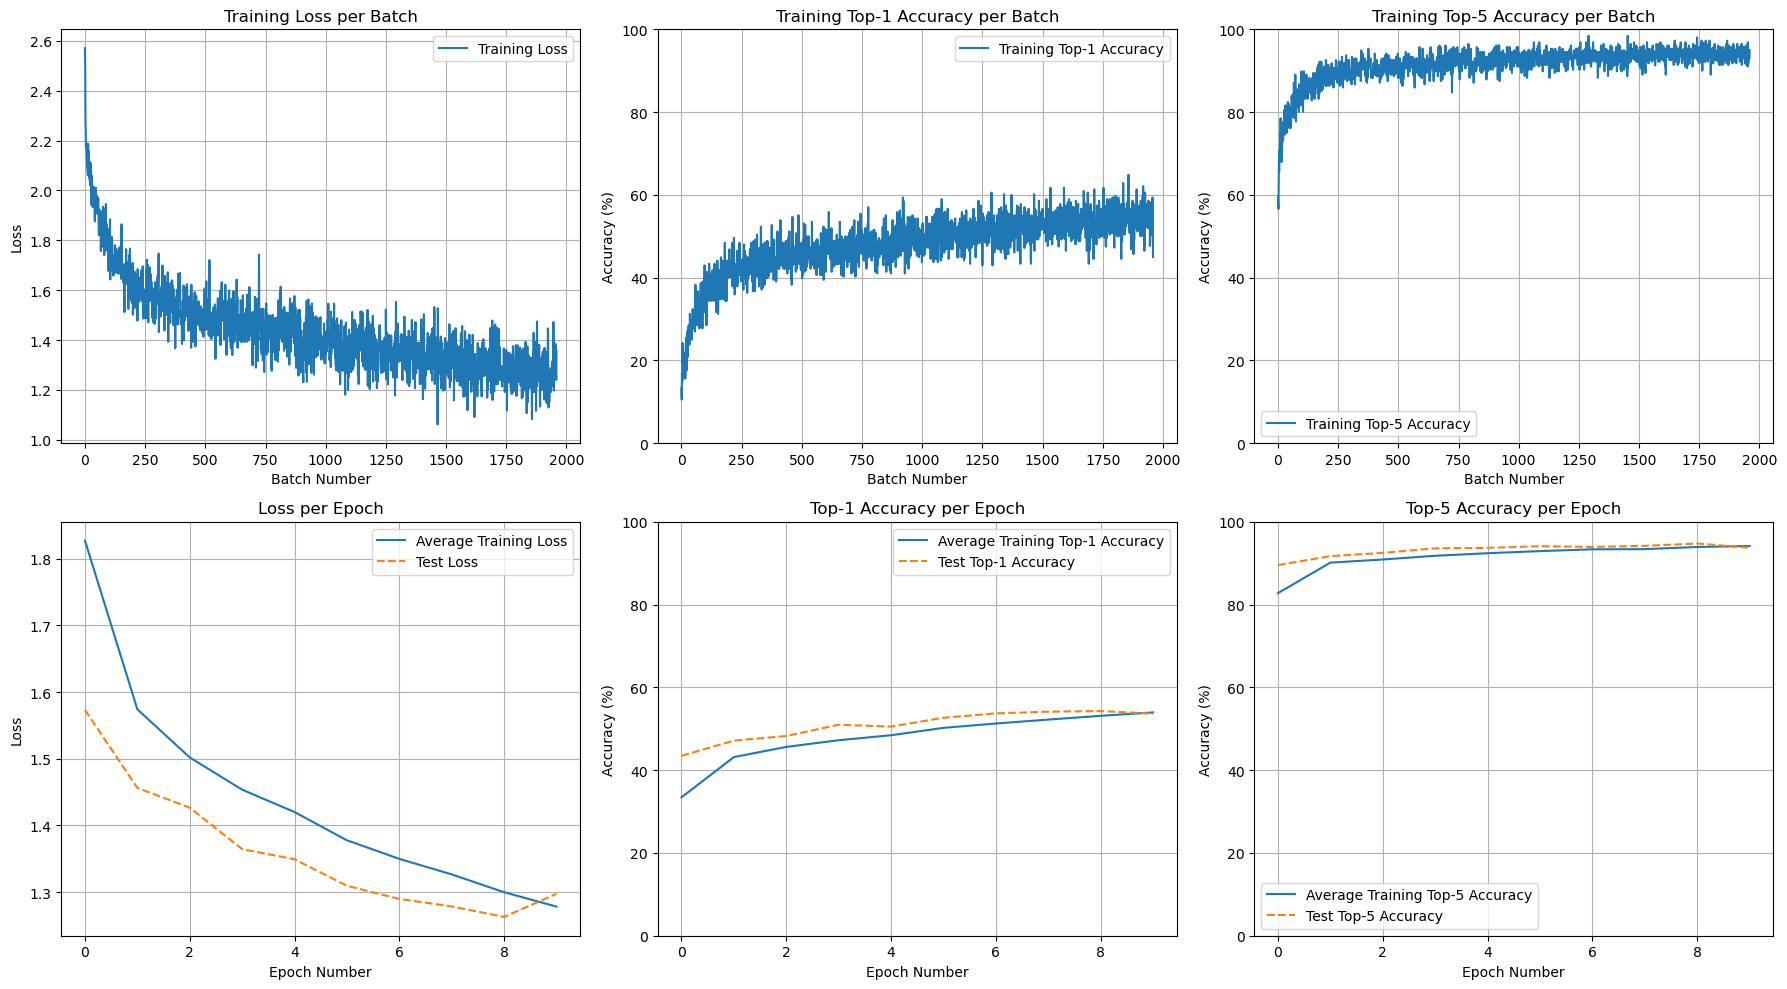

In [70]:
# 可视化代码
import numpy as np
import matplotlib.pyplot as plt

# 确保转换回CPU并转换成numpy数组
train_loss = np.array(train_loss)
train_accuracy_top1 = np.array(train_accuracy_top1)
train_accuracy_top5 = np.array(train_accuracy_top5)
train_epoch_loss = np.array(train_epoch_loss)
train_epoch_accuracy_top1 = np.array(train_epoch_accuracy_top1)
train_epoch_accuracy_top5 = np.array(train_epoch_accuracy_top5)

test_loss = np.array(test_loss)
test_accuracy_top1 = np.array(test_accuracy_top1)
test_accuracy_top5 = np.array(test_accuracy_top5)

plt.figure(figsize=(18, 10))

# 绘制训练损失曲线
plt.subplot(2, 3, 1)
plt.plot(range(len(train_loss)), train_loss, label='Training Loss')
plt.title('Training Loss per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# 绘制训练Top-1准确率曲线
plt.subplot(2, 3, 2)
plt.plot(range(len(train_accuracy_top1)), train_accuracy_top1, label='Training Top-1 Accuracy')
plt.title('Training Top-1 Accuracy per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Accuracy (%)')
plt.ylim([0, 100])
plt.grid(True)
plt.legend()

# 绘制训练Top-5准确率曲线
plt.subplot(2, 3, 3)
plt.plot(range(len(train_accuracy_top5)), train_accuracy_top5, label='Training Top-5 Accuracy')
plt.title('Training Top-5 Accuracy per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Accuracy (%)')
plt.ylim([0, 100])
plt.grid(True)
plt.legend()

# 绘制每个epoch的平均训练损失曲线
plt.subplot(2, 3, 4)
plt.plot(range(len(train_epoch_loss)), train_epoch_loss, label='Average Training Loss')
plt.plot(range(len(test_loss)), test_loss, label='Test Loss', linestyle='--')
plt.title('Loss per Epoch')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# 绘制每个epoch的平均训练Top-1准确率曲线
plt.subplot(2, 3, 5)
plt.plot(range(len(train_epoch_accuracy_top1)), train_epoch_accuracy_top1, label='Average Training Top-1 Accuracy')
plt.plot(range(len(test_accuracy_top1)), test_accuracy_top1, label='Test Top-1 Accuracy', linestyle='--')
plt.title('Top-1 Accuracy per Epoch')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy (%)')
plt.ylim([0, 100])
plt.grid(True)
plt.legend()

# 绘制每个epoch的平均训练Top-5准确率曲线
plt.subplot(2, 3, 6)
plt.plot(range(len(train_epoch_accuracy_top5)), train_epoch_accuracy_top5, label='Average Training Top-5 Accuracy')
plt.plot(range(len(test_accuracy_top5)), test_accuracy_top5, label='Test Top-5 Accuracy', linestyle='--')
plt.title('Top-5 Accuracy per Epoch')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy (%)')
plt.ylim([0, 100])
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

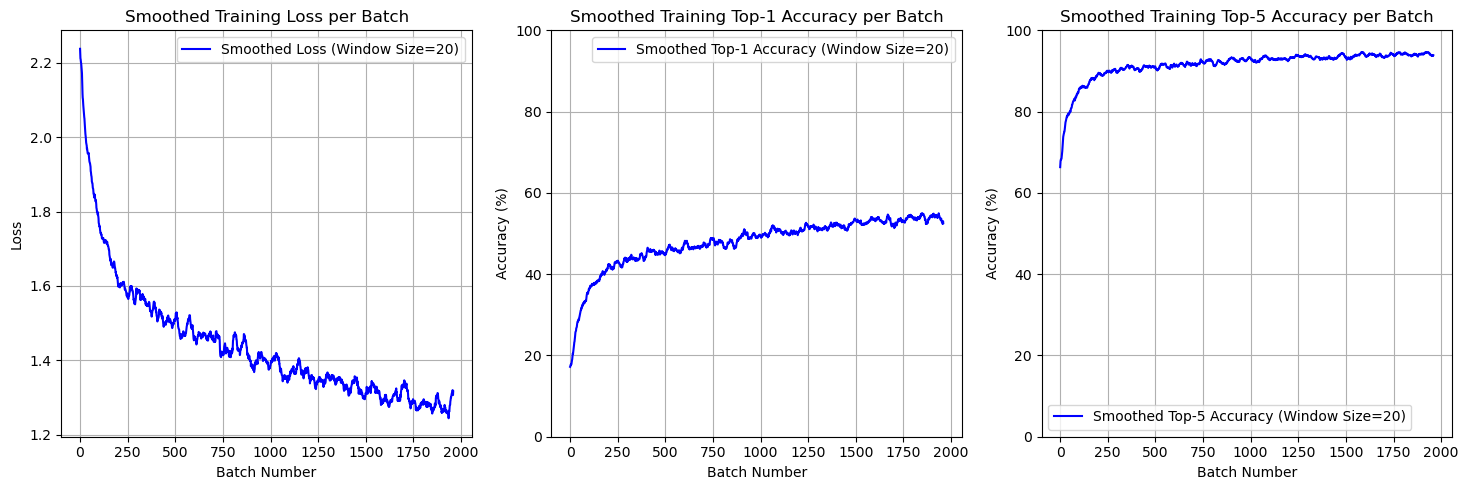

In [72]:
def smooth_curve(points, window_size):
    """
    对数据点进行移动平均平滑处理。
    :param points: 原始数据点列表
    :param window_size: 平滑窗口的大小
    :return: 平滑后的数据点列表
    """
    if window_size < 2:
        return points
    
    smoothed_points = []
    for idx in range(len(points)):
        start = max(0, idx - window_size//2)
        end = min(len(points), idx + window_size//2 + 1)
        window = points[start:end]
        avg = sum(window) / len(window)
        smoothed_points.append(avg)
    
    return smoothed_points

# 平滑数据
window_size = 20
smoothed_train_loss = smooth_curve(train_loss, window_size)
smoothed_train_accuracy_top1 = smooth_curve(train_accuracy_top1, window_size)
smoothed_train_accuracy_top5 = smooth_curve(train_accuracy_top5, window_size)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(smoothed_train_loss, label=f'Smoothed Loss (Window Size={window_size})', color='blue')
plt.title('Smoothed Training Loss per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# 绘制平滑后的训练Top-1准确率曲线
plt.subplot(1, 3, 2)
plt.plot(smoothed_train_accuracy_top1, label=f'Smoothed Top-1 Accuracy (Window Size={window_size})', color='blue')
plt.title('Smoothed Training Top-1 Accuracy per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Accuracy (%)')
plt.ylim([0, 100])
plt.grid(True)
plt.legend()

# 绘制平滑后的训练Top-5准确率曲线
plt.subplot(1, 3, 3)
plt.plot(smoothed_train_accuracy_top5, label=f'Smoothed Top-5 Accuracy (Window Size={window_size})', color='blue')
plt.title('Smoothed Training Top-5 Accuracy per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Accuracy (%)')
plt.ylim([0, 100])
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [73]:
# 定义一个函数来保存模型
def save_model(model, optimizer, filename='../Model/model.pth'):
    state = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(state, filename)
    print(f'Model and optimizer state saved to {filename}')

# 定义一个函数来加载模型
def load_model(model, optimizer, filename='../Model/model.pth'):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print(f'Model and optimizer state loaded from {filename}')

# ...（训练部分保持不变）
# 假设mylenet是你的模型实例，optimizer是你的优化器实例
save_model(MyViT, optimizer,filename = '../Model/CatAndDog/MyViT.pth')

# 稍后若要恢复训练或使用模型：
# 加载模型和优化器状态
load_model(MyViT, optimizer,filename = '../Model/CatAndDog/MyViT.pth')

Model and optimizer state saved to ../Model/CatAndDog/MyViT.pth
Model and optimizer state loaded from ../Model/CatAndDog/MyViT.pth


In [74]:
import torch
import torch.onnx

# 假设model是已加载并设置为eval模式的ResNet模型
MyViT.eval()

# 定义模型的输入形状，根据您的实际情况调整
input_shape = (1, 3, 32, 32)  # 调整为您的输入尺寸

# 创建一个与模型输入尺寸匹配的dummy_input
dummy_input = torch.randn(input_shape, device=MyViT.parameters().__next__().device)  # 使用随机数据作为示例输入，并放置在与模型相同的设备上

# 导出模型到ONNX
onnx_file_path = "../Model/CatAndDog/MyViT.onnx"
torch.onnx.export(MyViT,               # 要导出的模型
                  dummy_input,         # 示例输入数据
                  onnx_file_path,      # 输出的ONNX文件路径
                  export_params=True,  # 将模型参数包含进ONNX文件
                  opset_version=12,    # ONNX操作集版本，选择适合您需求的版本
                  do_constant_folding=True,  # 执行常量折叠优化
                  input_names = ['input'],   # 输入的名称
                  output_names = ['output'],  # 输出的名称
                  dynamic_axes={'input': {0: 'batch_size'},    # 动态轴，允许batch_size变化
                               'output': {0: 'batch_size'}})

print(f"Model has been successfully converted to ONNX: {onnx_file_path}")

Model has been successfully converted to ONNX: ../Model/CatAndDog/MyViT.onnx


### 预测示例

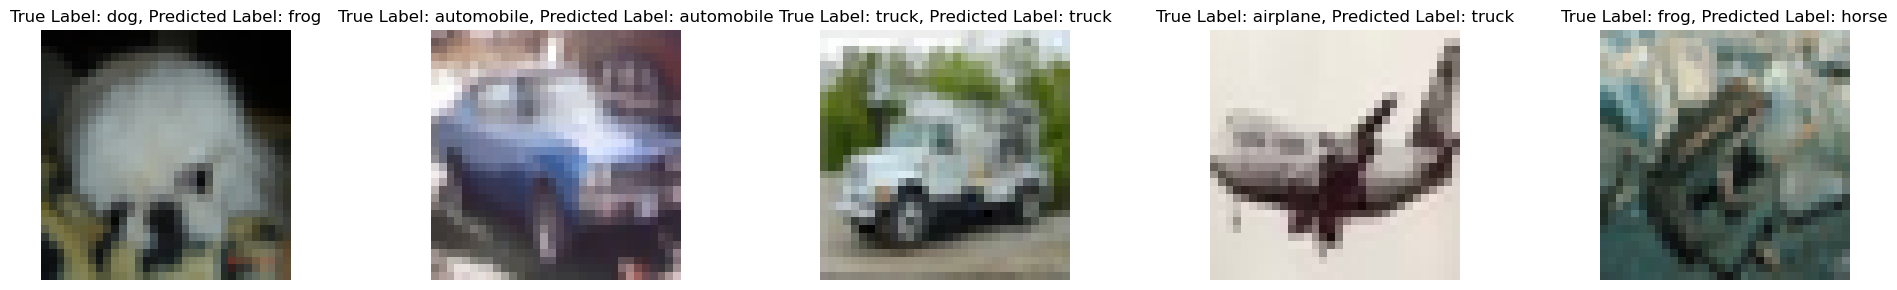

In [75]:
import random
import matplotlib.pyplot as plt

label_list = [ "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse","ship", "truck"]

# 设置要抽取的样本数量
num_samples_to_show = 5

# 随机抽取索引
random_indices = random.sample(range(len(testDataLoader.dataset)),num_samples_to_show)

# 创建一个子图画布，num_samples_to_show列，1行
fig, axs = plt.subplots(1, num_samples_to_show,figsize=(20, 3))  # 调整figsize以适应你的展示需求

# 对每个随机索引的样本进行预测并显示
for idx, ax in zip(random_indices, axs.flat):
    # 获取测试集中的随机样本
    img, true_label = testDataLoader.dataset[idx]
    
    # 将样本移动到设备（GPU或CPU），并准备用于模型预测  
    img = img.unsqueeze(0).to(device)
    imgC = img.cpu()
    
    img_unnormalized = reverse_normalize(imgC, mean, std)
    
    img_unnormalized=img_unnormalized.squeeze(0)
    # 使用模型进行预测
    with torch.no_grad():
        output = MyViT(img)

    # 获取预测类别
    predicted_label = torch.argmax(output, dim=1).item()

    # 显示原始图像到对应的子图
    ax.imshow(img_unnormalized.permute(1, 2, 0))  # 如果img是CHW格式，则需 permute(1, 2, 0) 转换为HWC格式
    ax.set_title(f"True Label: {label_list[true_label]}, Predicted Label: {label_list[predicted_label]}")
    ax.axis('off')  # 关闭坐标轴显示，使图像更整洁

# 显示画布
plt.tight_layout()  # 自动调整子图间距
plt.show()

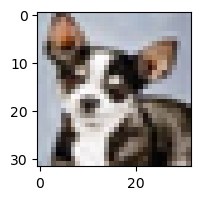

True Label: dog , Predicted Label: dog


In [94]:
# 首先，定义一个函数来加载和预处理图像
def load_and_preprocess_image(image_path, image_size):
    # 使用PIL库加载图像
    image = Image.open(image_path).convert("RGB")  # 将图像转换为RGB格式，确保图像具有三个通道
    plt.figure(figsize=(2, 2))
    plt.imshow(image)   
    plt.show()
    # 定义转换器来将图像大小调整为所需的大小，并将其转换为PyTorch张量
    preprocess = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        #transforms.RandomHorizontalFlip(),
        #transforms.RandomGrayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    # 应用转换器到图像
    image = preprocess(image)
    
    # 返回处理后的图像
    return image

# 定义图像路径和图像大小
image_path = "../data/CatAndDog/dog.png"  
image_size = 32  

# 加载和预处理图像
input_image = load_and_preprocess_image(image_path, image_size)

img = input_image.unsqueeze(0).to(device)
# 执行评估（假设model是您的模型）
output = MyViT(img)  # 将图像添加批次维度并传递给模型
predicted_label = torch.argmax(output, dim=1).item()

print(f"True Label: dog , Predicted Label: {label_list[predicted_label]}")

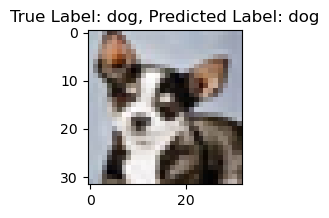

In [102]:
label_list = [
    "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse",
    "ship", "truck"
]

# 首先，定义一个函数来加载和预处理图像
def preprocess_image(image, image_size):
    # 定义转换器来将图像大小调整为所需的大小，并将其转换为PyTorch张量
    preprocess = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        # transforms.RandomHorizontalFlip(),
        # transforms.RandomGrayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    # 应用转换器到图像
    img = preprocess(image)
    # 返回处理后的图像
    return img

image_path = "../data/CatAndDog/dog.png"
image_size = 32

# 读取图片，这里假设图片是彩色的
img_bgr = cv2.imread(image_path)
# 从BGR色彩空间转换为RGB，以便PIL处理
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_pil = Image.fromarray(img_rgb)
# 对图像进行预处理
img_preprocessed = preprocess_image(img_pil, image_size)
# 添加批量维度并将其移到设备上
img_input = img_preprocessed.unsqueeze(0).to(device)

# 使用模型进行预测
with torch.no_grad():
    output = MyViT(img_input)

# 获取预测类别
predicted_label = torch.argmax(output, dim=1).item()

plt.figure(figsize=(2, 2))
plt.imshow(img_pil)
plt.title(f"True Label: dog, Predicted Label: {label_list[predicted_label]}")
plt.show()